<a href="https://colab.research.google.com/github/LeoLe12/NLP_PubMedQA/blob/main/Copia_di_Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🩻 **NLP Project - PubMedQ&A**

---



**Group:** DROP TABLE

**Members:** FRAGERI Martina, GUAZZI Alessandro, LEI Leonardo, MANTEGAZZA Niccolò, MOIANA Laura

Link to the 5-minute video: https://polimi365-my.sharepoint.com/:v:/g/personal/10733956_polimi_it/EZJZp0a9xa5Ao0WFPfbJUHIBnF5Ta609AiXl1yaOj6LjzQ?e=jL3lgY&nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJTdHJlYW1XZWJBcHAiLCJyZWZlcnJhbFZpZXciOiJTaGFyZURpYWxvZy1MaW5rIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXcifX0%3D

# ⚙️ Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from transformers import BertTokenizer
import re
from tqdm import tqdm
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from torch.utils.data import Dataset, TensorDataset, DataLoader
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# 🛢️ Import data

The dataset is organized in 3 subsets:


*   PQA-L (1k): labeled
*   PQA-A (~211k): artificially created Q&A
*   PQA-U (~61k): unlabeled







In [ ]:
pqa_l = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-L.parquet')
pqa_a = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-A.parquet')
pqa_u = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-U.parquet')

# 🔎 Preliminary analysis

## 📊 Dataset description





Each subset is composed of 5 columns (4 for the unlabeled):


*   Pubid: ID
*   Question
*   Context
*   Long Answer
*   final_decision: yes/no/maybe

So, we can make different tasks:


1.   **CLASSIFICATION**: classify into yes/no/maybe
2.   **Q&A**: generate the long answer given the question and context










In [ ]:
print(pqa_l.columns)
print(pqa_a.columns)
print(pqa_u.columns)
pqa_l

# as expected the unlabeled dataset doesn't contain the "final decision" column

Index(['pubid', 'question', 'context', 'long_answer', 'final_decision'], dtype='object')
Index(['pubid', 'question', 'context', 'long_answer', 'final_decision'], dtype='object')
Index(['pubid', 'question', 'context', 'long_answer'], dtype='object')


pubid                                           question  \
0    21645374  Do mitochondria play a role in remodelling lac...   
1    16418930  Landolt C and snellen e acuity: differences in...   
2     9488747  Syncope during bathing in infants, a pediatric...   
3    17208539  Are the long-term results of the transanal pul...   
4    10808977  Can tailored interventions increase mammograph...   
..        ...                                                ...   
995   8921484  Does gestational age misclassification explain...   
996  16564683  Is there any interest to perform ultrasonograp...   
997  23147106  Is peak concentration needed in therapeutic dr...   
998  21550158  Can autologous platelet-rich plasma gel enhanc...   
999  17559449  Are sugars-free medicines more erosive than su...   

                                               context  \
0    {'contexts': ['Programmed cell death (PCD) is ...   
1    {'contexts': ['Assessment of visual acuity dep...   
2    {'contexts': ['Apparent life-threatening event...   
3    {'contexts': ['The transanal endorectal pull-t...   
4    {'contexts': ['Telephone counseling and tailor...   
..                                                 ...   
995  {'contexts': ['After 34 weeks gestation, summa...   
996  {'contexts': ['To evaluate the accuracy of ult...   
997  {'contexts': ['We analyzed the pharmacokinetic...   
998  {'contexts': ['This investigation assesses the...   
999  {'contexts': ['The reduced use of sugars-conta...   

                                           long_answer final_decision  
0    Results depicted mitochondrial dynamics in viv...            yes  
1    Using the charts described, there was only a s...             no  
2    "Aquagenic maladies" could be a pediatric form...            yes  
3    Our long-term study showed significantly bette...             no  
4    The effects of the intervention were most pron...            yes  
..                                                 ...            ...  
995  Gestational age misclassification is an unlike...             no  
996  Sonography has no place in the diagnosis of un...             no  
997  These results suggest little need to use peak ...             no  
998  The PRP group recorded reduced pain, swelling,...            yes  
999  Paediatric SF medicines were not more erosive ...             no  

[1000 rows x 5 columns]

### • dataset size

In [ ]:
print(f"PQA-L: {len(pqa_l)} samples")
print(f"PQA-A: {len(pqa_a)} samples")
print(f"PQA-U: {len(pqa_u)} samples")


PQA-L: 1000 samples
PQA-A: 211269 samples
PQA-U: 61249 samples


### • Preprocessing

In [ ]:
pqa_l["context"][0]

{'contexts': array(['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.',
        'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondri

Context column is a dictionary.

It contains different keys including:


*   "contexts": A list of strings, where each string provides different pieces of information about the context (like methodology, results, etc.).
*    Other keys such as "labels", "meshes", and others, which contain different types of metadata


I think only the information under the key context are useful => extract them and trasform in string

In [ ]:
def string_dataframe(df):
    df['context'] = df['context'].apply(
        lambda x: ' '.join(x['contexts']) if isinstance(x, dict) and 'contexts' in x else str(x)
    )

    df['question'] = df['question'].apply(lambda x: str(x))
    df['long_answer'] = df['long_answer'].apply(lambda x: str(x))

    return df

pqa_l= string_dataframe(pqa_l)
pqa_a= string_dataframe(pqa_a)
pqa_u = string_dataframe(pqa_u)

pqa_l["context"][0]


'Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants. The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondrial dye MitoTracker Red CMXRos a

PRE-PROCESSING :


*   lower case
*   remove useless punctuation
*   tokenization
*   remove stopwords (English)
*   lemmatization



In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    text = text.lower()  # lower case
    text = ''.join([char for char in text if char not in string.punctuation]) # remove punctuation
    text = re.sub(r'(\d+)([a-zA-Z])', r'\1 \2', text) # separate number and words
    words = nltk. word_tokenize(text) # tokenize
    words = [w for w in words if w not in stop_words]    # remove stopwords
    words = [w for w in words if len(w) > 1]  # rimuovi parole troppo corte
    #words = [stemmer.stem(w) for w in words]     #  stemming
    words = [lemmatizer.lemmatize(w) for w in words]  # lemmatization
    return " ".join(words)


def preprocess_dataset(df, columns):
    for col in columns:
        df[col] = df[col].apply(preprocess)
    return df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
preprocess(pqa_l["context"][0])

'programmed cell death pcd regulated death cell within organism lace plant aponogeton madagascariensis produce perforation leaf pcd leaf plant consist latticework longitudinal transverse vein enclosing areoles pcd occurs cell center areoles progress outwards stopping approximately five cell vasculature role mitochondrion pcd recognized animal however less studied pcd plant following paper elucidates role mitochondrial dynamic developmentally regulated pcd vivo madagascariensis single areole within window stage leaf pcd occurring divided three area based progression pcd cell undergo pcd npcd cell early stage pcd epcd cell late stage pcd lpcd window stage leaf stained mitochondrial dye mitotracker red cmxros examined mitochondrial dynamic delineated four category m1 m4 based characteristic including distribution motility membrane potential δψm tunel assay showed fragmented ndna gradient mitochondrial stage chloroplast transvacuolar strand also examined using live cell imaging possible im

In [ ]:
columns_to_preprocess = ['question', 'context', 'long_answer']

pqa_l = preprocess_dataset(pqa_l, columns_to_preprocess)
pqa_u = preprocess_dataset(pqa_u, columns_to_preprocess)
pqa_a = preprocess_dataset(pqa_a, columns_to_preprocess)

## save
pqa_l.to_csv('/content/drive/MyDrive/NLP/Assignment/pqa_l_clean.csv', index=False)
pqa_u.to_csv('/content/drive/MyDrive/NLP/Assignment/pqa_u_clean.csv', index=False)
pqa_a.to_csv('/content/drive/MyDrive/NLP/Assignment/pqa_a_clean.csv', index=False)


In [ ]:
# upload
pqa_l = pd.read_csv('/content/drive/MyDrive/NLP/Assignment/pqa_l_clean.csv')
pqa_u = pd.read_csv('/content/drive/MyDrive/NLP/Assignment/pqa_u_clean.csv')
pqa_a = pd.read_csv('/content/drive/MyDrive/NLP/Assignment/pqa_a_clean.csv')
pqa_l_original = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-L.parquet')
pqa_u_original = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-U.parquet')
pqa_a_original = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-A.parquet')

### • document Length

In [ ]:
## original length
q_len_l, c_len_l, la_len_l = get_lengths(pqa_l_original)
q_len_a, c_len_a, la_len_a = get_lengths(pqa_a_original)
q_len_u, c_len_u, la_len_u = get_lengths(pqa_u_original)

print("AVERAGE LENGTH:")
print(f"\nPQA-L__________________________")
print(f"Question: {q_len_l.mean():.2f} words")
print(f"Context: {c_len_l.mean():.2f} words")
print(f"Long Answer: {la_len_l.mean():.2f} words")

print(f"\nPQA-A__________________________")
print(f"Question: {q_len_a.mean():.2f} words")
print(f"Context: {c_len_a.mean():.2f} words")
print(f"Long Answer: {la_len_a.mean():.2f} words")

print(f"\nPQA-U__________________________")
print(f"Question: {q_len_u.mean():.2f} words")
print(f"Context: {c_len_u.mean():.2f} words")
print(f"Long Answer: {la_len_u.mean():.2f} words")

AVERAGE LENGTH:

PQA-L__________________________
Question: 12.91 words
Context: 244.67 words
Long Answer: 39.66 words

PQA-A__________________________
Question: 15.34 words
Context: 235.53 words
Long Answer: 37.59 words

PQA-U__________________________
Question: 13.35 words
Context: 233.77 words
Long Answer: 42.02 words


In [ ]:
## length after preprocessing
def get_lengths(df):
    question_lengths = df['question'].apply(lambda x: len(str(x).split()))#re.findall(r'\b\w+\b', x))) #(tokenizer.tokenize(x)))
    context_lengths = df['context'].apply(lambda x: len(str(x).split()))#re.findall(r'\b\w+\b', x)))
    long_answer_lengths = df['long_answer'].apply(lambda x: len(str(x).split()))#re.findall(r'\b\w+\b', x)))
    return question_lengths, context_lengths, long_answer_lengths

q_len_l, c_len_l, la_len_l = get_lengths(pqa_l)
q_len_a, c_len_a, la_len_a = get_lengths(pqa_a)
q_len_u, c_len_u, la_len_u = get_lengths(pqa_u)

print("AVERAGE LENGTH:")
print(f"\nPQA-L__________________________")
print(f"Question: {q_len_l.mean():.2f} words")
print(f"Context: {c_len_l.mean():.2f} words")
print(f"Long Answer: {la_len_l.mean():.2f} words")

print(f"\nPQA-A__________________________")
print(f"Question: {q_len_a.mean():.2f} words")
print(f"Context: {c_len_a.mean():.2f} words")
print(f"Long Answer: {la_len_a.mean():.2f} words")

print(f"\nPQA-U__________________________")
print(f"Question: {q_len_u.mean():.2f} words")
print(f"Context: {c_len_u.mean():.2f} words")
print(f"Long Answer: {la_len_u.mean():.2f} words")


AVERAGE LENGTH:

PQA-L__________________________
Question: 8.76 words
Context: 127.92 words
Long Answer: 24.40 words

PQA-A__________________________
Question: 10.69 words
Context: 130.95 words
Long Answer: 23.98 words

PQA-U__________________________
Question: 9.08 words
Context: 127.06 words
Long Answer: 25.84 words



PQA-L
minimum lenght: 24
maximum lenght: 245
mean lenght: 127.92
median lenght: 128.0

PQA-A
minimum lenght: 1
maximum lenght: 650
mean lenght: 130.95
median lenght: 130.0

PQA-U
minimum lenght: 14
maximum lenght: 478
mean lenght: 127.06
median lenght: 125.0


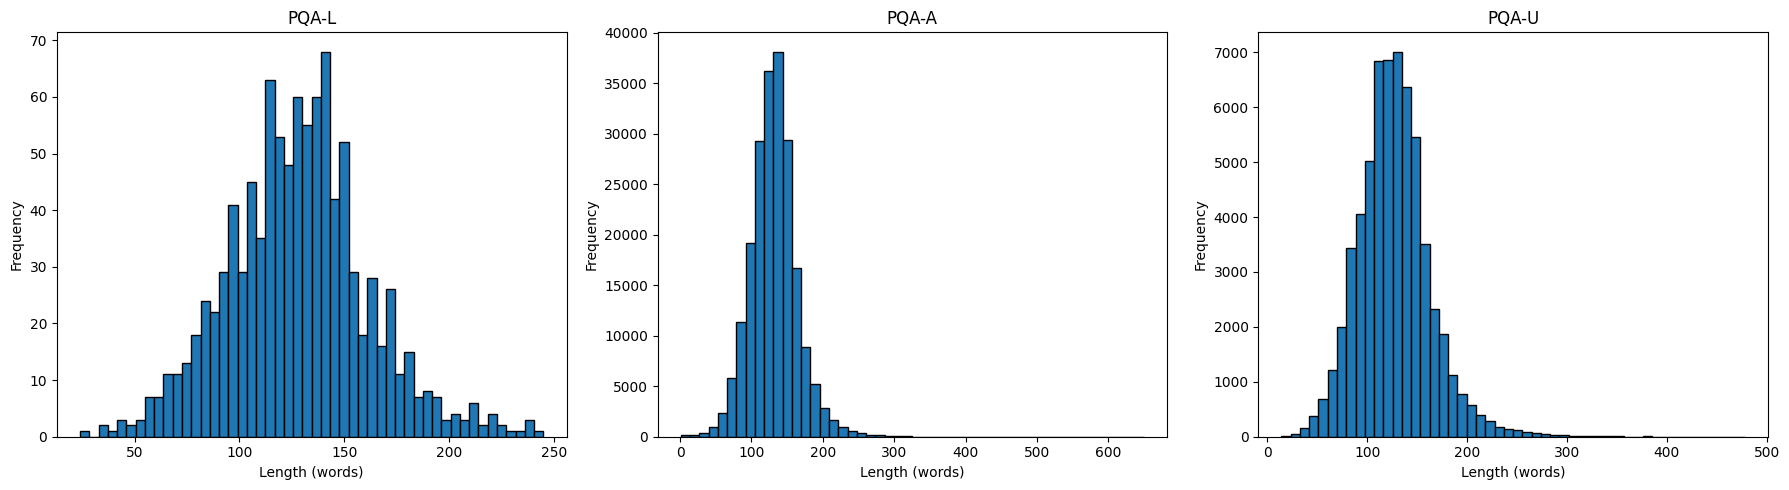

In [ ]:
## only "context" statistics
def compute_document_lengths(dataset):
    return dataset['context'].apply(lambda x: len(str(x).split()))#re.findall(r'\b\w+\b', str(x))))

def compute_statistics_and_plot(lengths, title, ax):
    min_length = lengths.min()
    max_length = lengths.max()
    mean_length = lengths.mean()
    median_length = lengths.median()

    print(f"\n{title}")
    print(f"minimum lenght: {min_length}")
    print(f"maximum lenght: {max_length}")
    print(f"mean lenght: {mean_length:.2f}")
    print(f"median lenght: {median_length}")

    ax.hist(lengths, bins=50, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Length (words)')
    ax.set_ylabel('Frequency')

# lenght
lengths_pqa_l = compute_document_lengths(pqa_l)
lengths_pqa_a = compute_document_lengths(pqa_a)
lengths_pqa_u = compute_document_lengths(pqa_u)

# visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
compute_statistics_and_plot(lengths_pqa_l, "PQA-L", axes[0])
compute_statistics_and_plot(lengths_pqa_a, "PQA-A", axes[1])
compute_statistics_and_plot(lengths_pqa_u, "PQA-U", axes[2])

plt.tight_layout()
plt.show()

### • Vocabulary size

In [ ]:
# Nan
print("PQA_L")
print(pqa_l.isna().sum())
print("\nPQA_A")
print(pqa_a.isna().sum())
print("\nPQA_U")
print(pqa_u.isna().sum())

PQA_L
pubid             0
question          0
context           0
long_answer       0
final_decision    0
dtype: int64

PQA_A
pubid              0
question           0
context            1
long_answer       10
final_decision     0
dtype: int64

PQA_U
pubid          0
question       5
context        0
long_answer    1
dtype: int64


In [ ]:
# see the difference between original and post-processed (to see why Nan appear)
for idx in pqa_u[pqa_u.isna().any(axis=1)].index:
    original_row = pqa_u_original.iloc[idx]
    current_row = pqa_u.iloc[idx]
    differences = current_row != original_row

    if differences.any():
        print(f"Index: {idx}")
        print("Differences:")
        for col in pqa_u.columns[differences]:
            print(f"  Column: {col}")
            print(f"    Original: {original_row[col]}")
            print(f"    Current: {current_row[col]}")
            print("-" * 40)

# as we can see some question such as "down or up" are completely removed => Nan

Index: 6567
Differences:
  Column: question
    Original: Down or up?
    Current: nan
----------------------------------------
  Column: context
    Original: {'contexts': array(["Some studies find that parents of children with Down's syndrome may experience symptoms of depression, while other studies find that parents adapt well. This study aimed to clarify this variability in adaptive strength by investigating a stress-coping model to explain depressive symptoms and positive affect.",
       "Questionnaires were completed by 553 parents of children (aged 0-18) with Down's syndrome, containing measures of goal disturbance, cognitive coping, social support, partner bonding, and coping self-efficacy.",
       'Different models for positive affect and depressive symptoms were found. The coping strategies of self-blame and rumination were positively related to depressive symptoms, and positive reappraisal was positively related to positive affect. Partner bonding characteristics played r

In [ ]:
## remove rows with Nan
pqa_l_cleaned = pqa_l.dropna(subset=["question", "context", "long_answer"])
pqa_a_cleaned = pqa_a.dropna(subset=["question", "context", "long_answer"])
pqa_u_cleaned = pqa_u.dropna(subset=["question", "context", "long_answer"])


In [ ]:
# Nan after
print("PQA_L")
print(pqa_l_cleaned.isna().sum())
print("\nPQA_A")
print(pqa_a_cleaned.isna().sum())
print("\nPQA_U")
print(pqa_u_cleaned.isna().sum())

PQA_L
pubid             0
question          0
context           0
long_answer       0
final_decision    0
dtype: int64

PQA_A
pubid             0
question          0
context           0
long_answer       0
final_decision    0
dtype: int64

PQA_U
pubid          0
question       0
context        0
long_answer    0
dtype: int64


Calculate the vocabulary size.
1.   Without removing the numbers
2.   Removing the numbers

In [ ]:
## 1. WITHOUT REMOVING THE NUMBERS
def build_vocab(df, columns, rare_threshold=1, high_percentile=90):
    all_text = " ".join(df[columns].fillna("").apply(lambda row: " ".join(row), axis=1).tolist())
    word_counts = Counter(all_text.split())

    frequencies = list(word_counts.values())
    high_threshold = np.percentile(frequencies, high_percentile)
    vocab = {w for w, c in word_counts.items() if rare_threshold < c < high_threshold}
    return vocab


vocab_l = build_vocab(pqa_l_cleaned, columns=["question", "context", "long_answer"])
print(f"Vocabulary size (PQA-L): {len(vocab_l)} words")
sorted_vocab_l = sorted(vocab_l)
print(sorted_vocab_l)

vocab_a = build_vocab(pqa_a_cleaned, columns=["question", "context", "long_answer"])
print(f"Vocabulary size (PQA-A): {len(vocab_a)} words")
sorted_vocab_a = sorted(vocab_a)
print(sorted_vocab_a)

vocab_u = build_vocab(pqa_u_cleaned, columns=["question", "context", "long_answer"])
print(f"Vocabulary size (PQA-U): {len(vocab_u)} words")
sorted_vocab_u = sorted(vocab_u)
print(sorted_vocab_u)

Vocabulary size (PQA-L): 8080 words
['00', '000', '0000', '000001', '00001', '00008', '00013', '00018', '0002', '0003', '0004', '0006', '0007', '0008', '0009', '0011', '0012', '0013', '0015', '0016', '0018', '0019', '0021', '0022', '0023', '0024', '0025', '0026', '0028', '0029', '0031', '0032', '0033', '0035', '0036', '0037', '0038', '0039', '0041', '0044', '0046', '0047', '0048', '006', '007', '0076', '0077', '008', '0081', '0085', '009', '010', '0100', '011', '012', '0121', '0125', '013', '0133', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '0308', '031', '032', '0328', '033', '0336', '0337', '034', '035', '036', '037', '038', '0388', '039', '040', '0401', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '052', '053', '054', '054058', '0548', '055', '056', '0563', '057', '058', '059', '06', '060', '062', '063', '064', '065', '066', '067', '068', '069', '07', '070', '0702', '071', '072', '07

In [ ]:
## 2. REMOVING THE NUMBERS
def remove_numbers(text):
    # remove all the numbers from the text
    return re.sub(r'\d+', '', text)

def build_vocab(df, columns, rare_threshold=1, high_percentile=90):
    all_text = " ".join(df[columns].fillna("").apply(lambda row: " ".join(row), axis=1).tolist())
    all_text = remove_numbers(all_text)
    word_counts = Counter(all_text.split())

    frequencies = list(word_counts.values())
    high_threshold = np.percentile(frequencies, high_percentile)
    vocab = {w for w, c in word_counts.items() if rare_threshold < c < high_threshold}
    return vocab


vocab_l = build_vocab(pqa_l_cleaned, columns=["question", "context", "long_answer"])
print(f"Vocabulary size (PQA-L): {len(vocab_l)} words")
sorted_vocab_l = sorted(vocab_l)
print(sorted_vocab_l)

vocab_a = build_vocab(pqa_a_cleaned, columns=["question", "context", "long_answer"])
print(f"Vocabulary size (PQA-A): {len(vocab_a)} words")
sorted_vocab_a = sorted(vocab_a)
print(sorted_vocab_a)

vocab_u = build_vocab(pqa_u_cleaned, columns=["question", "context", "long_answer"])
print(f"Vocabulary size (PQA-U): {len(vocab_u)} words")
sorted_vocab_u = sorted(vocab_u)
print(sorted_vocab_u)


Vocabulary size (PQA-L): 7309 words
['a', 'aa', 'aaa', 'aabr', 'aac', 'aai', 'aaps', 'ab', 'abd', 'abdomen', 'abdominopelvic', 'abdominoplasty', 'aberrant', 'ablation', 'abnormal', 'abo', 'aborigine', 'abortion', 'aboveaverage', 'aboveknee', 'abp', 'abscess', 'absent', 'absite', 'absolute', 'absorbed', 'absorptiometry', 'absorption', 'abstract', 'abstracted', 'abuse', 'abuser', 'acc', 'accelerated', 'acceleration', 'accept', 'acceptability', 'acceptance', 'accepted', 'accepting', 'accessed', 'accessible', 'accessing', 'acci', 'accident', 'acclimation', 'accompanied', 'accordance', 'accordingly', 'accounted', 'accounting', 'accrual', 'accumulation', 'accurately', 'acd', 'acei', 'acetylcholine', 'ach', 'achievable', 'achieve', 'achieving', 'achilles', 'acidbase', 'acidity', 'acidosis', 'acidrelief', 'acknowledged', 'acl', 'aclr', 'acls', 'aclssapo', 'acmia', 'acq', 'acquired', 'acquisition', 'acr', 'acsnsqip', 'act', 'acth', 'acting', 'actinobaculum', 'action', 'activated', 'activator', 

## 📚 cluster

Clustering is an unsupervised learning technique used to group similar data points together based on their features. The goal is to discover inherent structures or patterns in the data without using labels.
So it can be used also with the unlabeled data. For this reason we are going perform it just on PQA_U.

In order to cluster the documents, we need first to convert them into a vector format. We will use the TfidfVectorizer from Scikit-Learn to do this. (intead of pyterrier)

The TfidfVectorizer is very similar to the CountVectorizer

In [ ]:
!pip install -q python-terrier==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.7 MB/s eta 0:00:00


In [ ]:
import pyterrier as pt

if not pt.started():
  pt.init()

# documents = [
#     f"{item['question']} {item['context']} {item['long_answer']}"
#     for item in pqa_l
# ]

documents = [
    f"{row['question']} {row['context']} {row['long_answer']}"
    for index, row in pqa_u.iterrows()
]

print(documents[:10])

<ipython-input-15-fc16eb283dfd>:3: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
<ipython-input-15-fc16eb283dfd>:4: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


['naturopathy effective conventional therapy treatment menopausal symptom although use alternative medicine united state increasing published study documented effectiveness naturopathy treatment menopausal symptom compared woman receiving conventional therapy clinical setting compare naturopathic therapy conventional medical therapy treatment selected menopausal symptom retrospective cohort study using abstracted data medical chart one natural medicine six conventional medical clinic community health center king county washington november 1996 july 31 1998 woman aged 40 year age diagnosis menopausal symptom documented naturopathic conventional physician improvement selected menopausal symptom univariate analysis patient treated naturopathy menopausal symptom reported higher monthly income 184800 versus 85360 less likely smoker 114 versus 419 exercised frequently reported higher frequency decreased energy 418 versus 244 insomnia 570 versus 331 hot flash 696 versus 556 baseline received 



*   max_df=0.8: don't consider words that appear in more than 80% of the documents (probably too frequent to be useful).
*   min_df=3: don't consider words that appear in less than 3 documents (could be errors or noise).

*  stop_words='english': remove the english stopwords  (ex: "the", "and", "is", ...).









In [ ]:
# remove numbers from the document as they don't provide information for clustering
documents = [re.sub(r'\d+', '', doc) for doc in documents]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=3, stop_words='english')

In [ ]:
# fit the data
vectorizer.fit(documents)

TfidfVectorizer(max_df=0.8, min_df=3, stop_words='english')

In [ ]:
# size of the resulting vocabolary filtered
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

# with numbers the vocabulary is 50750

Length of vocabulary: 41124


In [ ]:
# vectorize the document
vector_documents = vectorizer.transform(documents)

In [ ]:
print(vector_documents[0])  #each weight is the tf-idf of the word

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 88 stored elements and shape (1, 41124)>
  Coords	Values
  (0, 158)	0.059739446928550634
  (0, 827)	0.01970419614892936
  (0, 837)	0.03317756598010279
  (0, 1243)	0.07965677290683366
  (0, 1458)	0.039418123000757345
  (0, 1997)	0.04499464570552337
  (0, 2122)	0.039484226918759094
  (0, 2185)	0.041532042569237954
  (0, 3185)	0.032426571694870336
  (0, 5281)	0.033795319597604526
  (0, 5450)	0.026788027575755678
  (0, 5493)	0.04224084649026514
  (0, 5789)	0.17303062288573706
  (0, 6022)	0.037373122704822195
  (0, 6024)	0.02135087016970036
  (0, 6311)	0.029621451226506647
  (0, 6548)	0.03926915727843503
  (0, 6582)	0.031038857724470837
  (0, 6583)	0.037261351290849586
  (0, 6845)	0.03142906788129204
  (0, 7198)	0.2883082863561957
  (0, 7199)	0.14036766240597018
  (0, 7489)	0.05347701583656589
  (0, 8325)	0.02009695451641665
  (0, 8540)	0.06635952146359896
  :	:
  (0, 31487)	0.053267087986440996
  (0, 31665)	0.032142595406972875


In [ ]:
sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])

[('naturopathy', np.float64(0.5406721376374275)),
 ('menopausal', np.float64(0.4307376344735084)),
 ('conventional', np.float64(0.2883082863561957)),
 ('symptom', np.float64(0.2098775710844949)),
 ('naturopathic', np.float64(0.1902327918667096)),
 ('ci', np.float64(0.17303062288573706)),
 ('versus', np.float64(0.15752595141412415)),
 ('flash', np.float64(0.14905098497816735)),
 ('therapy', np.float64(0.1466351936464292)),
 ('conventionally', np.float64(0.14036766240597018)),
 ('insomnia', np.float64(0.13320786027272852)),
 ('hot', np.float64(0.1282479961212457)),
 ('treated', np.float64(0.11638984001094434)),
 ('energy', np.float64(0.09943522482969704)),
 ('improvement', np.float64(0.09936207206476207)),
 ('treatment', np.float64(0.08931206522217432)),
 ('medical', np.float64(0.08456947142392914)),
 ('documented', np.float64(0.08438521246881965)),
 ('reported', np.float64(0.08388479228071337)),
 ('medicine', np.float64(0.08186518273315141)),
 ('alternative', np.float64(0.07965677290683

### • K-Means

it's an unsupervised clustering algorithm that groups data into K clusters based on distance.

In [ ]:
from sklearn.cluster import KMeans

k = 7

kmeans = KMeans(n_clusters=k, max_iter=100, n_init=4, verbose=True, random_state=2307)
kmeans.fit(vector_documents)

Initialization complete
Iteration 0, inertia 116039.73374387999.
Iteration 1, inertia 59922.650171753055.
Iteration 2, inertia 59723.470220814874.
Iteration 3, inertia 59640.496205016214.
Iteration 4, inertia 59603.879871106015.
Iteration 5, inertia 59589.83266835963.
Iteration 6, inertia 59582.799043352126.
Iteration 7, inertia 59579.12370732431.
Iteration 8, inertia 59576.95089016459.
Iteration 9, inertia 59575.41541583531.
Iteration 10, inertia 59574.27973247144.
Iteration 11, inertia 59573.23480078058.
Iteration 12, inertia 59572.08254815274.
Iteration 13, inertia 59570.78517747484.
Iteration 14, inertia 59568.81888621674.
Iteration 15, inertia 59565.90724264177.
Iteration 16, inertia 59563.87711416706.
Iteration 17, inertia 59562.77634524639.
Iteration 18, inertia 59561.99182693789.
Iteration 19, inertia 59561.24228104306.
Iteration 20, inertia 59560.56336632058.
Iteration 21, inertia 59559.967206747235.
Iteration 22, inertia 59559.436697783625.
Iteration 23, inertia 59558.9487219

KMeans(max_iter=100, n_clusters=7, n_init=4, random_state=2307, verbose=True)

In [ ]:
labels = kmeans.labels_
print(labels)

[5 6 3 ... 6 2 5]


**CLUSTERING EVALUATION**

In [ ]:
from collections import Counter

cluster_counts = Counter(labels)
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} documenti")

Cluster 5: 26608 documenti
Cluster 6: 8231 documenti
Cluster 3: 12142 documenti
Cluster 1: 2517 documenti
Cluster 0: 2563 documenti
Cluster 2: 5203 documenti
Cluster 4: 3985 documenti


In [ ]:
## CLUSTER 0
# centroid
centroid = kmeans.cluster_centers_[0]

# Sort terms according to their weights
sorted_terms = centroid.argsort()[::-1]

# Print the first 20 closest terms
[vocab[j] for j in sorted_terms[:20]]

['pain',
 'depression',
 'symptom',
 'patient',
 'disorder',
 'depressive',
 'anxiety',
 'score',
 'treatment',
 'scale',
 'group',
 'study',
 'chronic',
 'bipolar',
 'outcome',
 'associated',
 'clinical',
 'disability',
 'physical',
 'questionnaire']

The closest words to the centroid help to understand the topic of the cluster.

Let's have a look to the most important words for each cluster to see if the cluster holds some significance.

#### • Top terms per clusters

In [ ]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

#print the top words for all the clusters
for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

# 0: mental health
# 1: child health
# 2: cancer
# 3: surgery
# 4: pregnancy
# 5: study/test (generic)
# 6: healthcare system

Top terms per cluster:
Cluster 0:	['pain', 'depression', 'symptom', 'patient', 'disorder', 'depressive', 'anxiety', 'score', 'treatment', 'scale']
Cluster 1:	['child', 'parent', 'year', 'age', 'group', 'asthma', 'study', 'adhd', 'health', 'school']
Cluster 2:	['cancer', 'patient', 'tumor', 'survival', 'breast', 'node', 'metastasis', 'stage', 'carcinoma', 'resection']
Cluster 3:	['patient', 'group', 'surgery', 'complication', 'mortality', 'outcome', 'year', 'postoperative', 'rate', 'day']
Cluster 4:	['woman', 'pregnancy', 'birth', 'delivery', 'risk', 'maternal', 'infant', 'men', 'group', 'weight']
Cluster 5:	['patient', 'group', 'study', 'level', 'control', 'disease', 'risk', 'case', 'test', 'treatment']
Cluster 6:	['health', 'care', 'student', 'patient', 'physician', 'medical', 'practice', 'service', 'resident', 'quality']


Metrics:
- WCSS (within cluster sum of squares): tell how near the samples are to the centroid. small is better.
- Silhouette coefficient: how clusters are well separated

In [ ]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 59506.94135600581
Silhouette coefficient: 0.0031580186749528517


### • Minibatch K-Means clustering

Mini-Batch K-Means is a faster, memory-efficient variant of K-Means that uses small random subsets (mini-batches) of the data to update cluster centroids. It significantly reduces computation time while still producing results close to standard K-Means, making it suitable for large datasets.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

k = 7

mb_kmeans = MiniBatchKMeans(n_clusters=k,batch_size=200, random_state=2307)
mb_kmeans.fit(vector_documents)

MiniBatchKMeans(batch_size=200, n_clusters=7, random_state=2307)

In [ ]:
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(mb_kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, mb_kmeans.labels_)))
print("\n")

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 59575.928759393726
Silhouette coefficient: 0.001233276905733035




As we can see from these metrics, the minibatch k-means produces similar but not identical clusters compared to the basic k-means.

In [ ]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

#print the top words for all the clusters
for i in range(mb_kmeans.n_clusters):
    centroid = mb_kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['patient', 'group', 'mortality', 'coronary', 'surgery', 'artery', 'complication', 'aortic', 'cardiac', 'valve']
Cluster 1:	['cancer', 'breast', 'prostate', 'patient', 'biopsy', 'psa', 'screening', 'woman', 'risk', 'colorectal']
Cluster 2:	['patient', 'group', 'study', 'treatment', 'year', 'woman', 'clinical', 'rate', 'score', 'level']
Cluster 3:	['care', 'health', 'patient', 'physician', 'service', 'practice', 'hospital', 'quality', 'medical', 'mental']
Cluster 4:	['patient', 'tumor', 'survival', 'node', 'cancer', 'metastasis', 'resection', 'carcinoma', 'lymph', 'recurrence']
Cluster 5:	['child', 'parent', 'year', 'age', 'group', 'school', 'study', 'health', 'asthma', 'childrens']
Cluster 6:	['diabetes', 'risk', 'patient', 'glucose', 'insulin', 'level', 'woman', 'bmi', 'cardiovascular', 'diabetic']


Searching for the best value for k

In [ ]:
performance = [MiniBatchKMeans(n_clusters=k, batch_size=500, random_state=2307).fit(vector_documents).inertia_ for k in range(1,50)]
performance

[60300.39289005091,
 60135.1148016112,
 59997.52427140131,
 59856.322357542325,
 59748.454975303255,
 59679.20540483462,
 59605.444459178725,
 59565.176949998524,
 59540.0487208673,
 59521.26939061476,
 59455.37616246714,
 59378.10594048417,
 59385.99536558003,
 59458.82771161583,
 59444.51968917666,
 59295.46681485959,
 59358.188305947275,
 59200.16606988489,
 59200.92890633074,
 59190.13261742267,
 59007.153065058745,
 58983.74063942612,
 58978.676954661074,
 58999.228429823735,
 58946.89157505421,
 58804.98875270468,
 58803.594923803066,
 58865.62839229187,
 58895.00290606814,
 58943.38148113665,
 58853.8257584279,
 58819.68224090897,
 58788.82700609949,
 58732.8166638949,
 58772.37065364508,
 58926.01973978975,
 58853.19478982798,
 58812.45505559404,
 58780.9836772888,
 58781.176464789285,
 58857.822160121075,
 58794.12524558686,
 58805.23262282179,
 58696.163130644294,
 58651.41663362043,
 58291.53173078251,
 58548.72415632653,
 58424.158508012595,
 58377.94561532168]

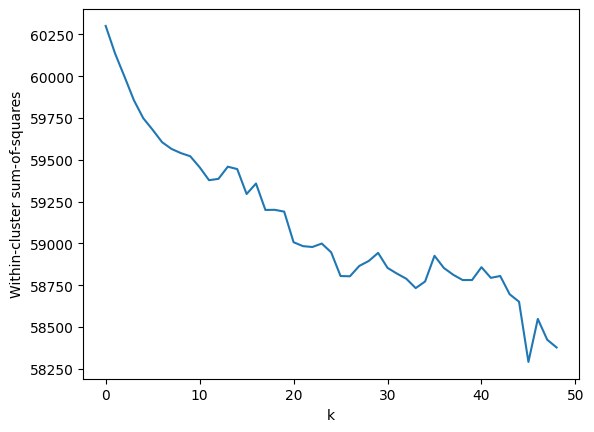

In [ ]:
plt.figure()
plt.plot(performance)
plt.ylabel('Within-cluster sum-of-squares')
plt.xlabel('k')
plt.show()

Looking at the graph we can see that around k=25 there is a slope change. So, probably k=25 is the best parameters.
We have used k=7 so further improvements could be done.

As expected using k=25 the performance improve (lower WCSS, higher Silhouette coeff)

In [ ]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 58399.03822230347
Silhouette coefficient: 0.006118734232793723


### • Clustering Visualization

For a bit of fun, we'll try to transform the high dimensional data into low dimensional data (just 3 dimensions) using a linear dimensionality reduction technique called Singular Value Decomposition.

We'll transform the vector_documents to be 3 dimensional.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(vector_documents)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

[array([0.16740305, 0.18558496, 0.23719015, ..., 0.19464012, 0.14898735,
        0.08236439]),
 array([-0.04286998, -0.10203891,  0.13584118, ..., -0.217045  ,
         0.13284838,  0.0123061 ]),
 array([ 0.02381835,  0.01789332, -0.10005862, ...,  0.10301344,
         0.07728669, -0.03132238])]

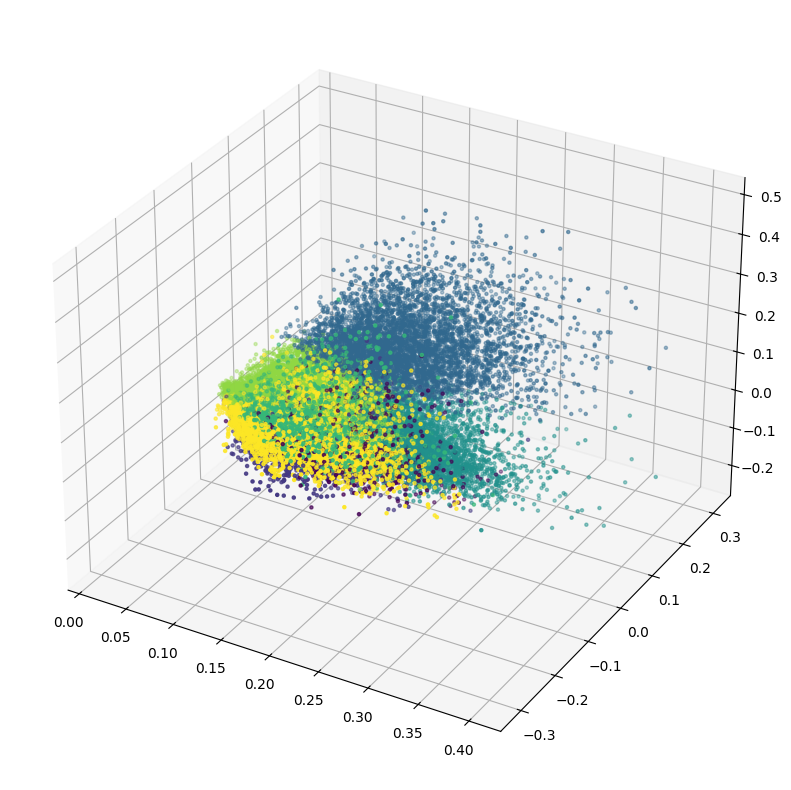

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

## basic kmeans
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(labels), marker='.');

## 🗂️ Index

Indexing is a critical step for efficient document retrieval. In this step, we process the dataset to create an **index** that maps terms or tokens (e.g., words) to the documents they appear in. This structure enables:
- **Faster Search**: Quickly locate documents containing query terms without scanning the entire dataset.
- **Efficient Ranking**: Support scoring mechanisms like TF-IDF or BM25 to rank documents by relevance.
- **Advanced Queries**: Allow handling of Boolean queries, similarity search, and other complex retrieval techniques.

In this notebook, we are creating an index from our dataset (`pubmedQA`) to facilitate efficient retrieval and further analysis. The indexing step transforms raw data into a structured format (e.g., an inverted index) suitable for search algorithms.

Key points:
- The index is stored for reuse, so it doesn't need to be recomputed for every query.
- It supports real-time retrieval pipelines for exploring the dataset.

In [ ]:
# !pip install -q python-terrier==0.11.0

In [ ]:
pd.set_option('display.max_colwidth', 150)

In [ ]:
import pyterrier as pt

if not pt.started():
  pt.init()

<ipython-input-13-ff2ffbf0b6dd>:3: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
<ipython-input-13-ff2ffbf0b6dd>:4: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [ ]:
# create columns "docno" and "text"
# concatenate question, context, long_answer in the "text" field to improve retrieval
docs_df_l = pqa_l.rename(columns={"pubid": "docno"}, inplace=False)
docs_df_a = pqa_a.rename(columns={"pubid": "docno"}, inplace=False)
docs_df_u = pqa_u.rename(columns={"pubid": "docno"}, inplace=False)

for df in [docs_df_l, docs_df_a, docs_df_u]:
    df["docno"] = df["docno"].astype(str)
    df["text"] = (
        df["question"].fillna("") + " "
        + df["context"].fillna("") + " "
        + df["long_answer"].fillna("")
    )

In [ ]:
docs_df_l

docno  \
0    21645374   
1    16418930   
2     9488747   
3    17208539   
4    10808977   
..        ...   
995   8921484   
996  16564683   
997  23147106   
998  21550158   
999  17559449   

                                                                                          question  \
0                        mitochondrion play role remodelling lace plant leaf programmed cell death   
1                                           landolt snellen acuity difference strabismus amblyopia   
2                                     syncope bathing infant pediatric form waterinduced urticaria   
3                           longterm result transanal pullthrough equal transabdominal pullthrough   
4                                   tailored intervention increase mammography use among hmo woman   
..                                                                                             ...   
995   gestational age misclassification explain difference birthweights australian aborigine white   
996                                        interest perform ultrasonography boy undescended testis   
997                               peak concentration needed therapeutic drug monitoring vancomycin   
998  autologous plateletrich plasma gel enhance healing surgical extraction mandibular third molar   
999                                          sugarsfree medicine erosive sugarscontaining medicine   

                                                                                                                                                   context  \
0    programmed cell death pcd regulated death cell within organism lace plant aponogeton madagascariensis produce perforation leaf pcd leaf plant cons...   
1    assessment visual acuity depends optotypes used measurement ability recognize different optotypes differs even critical detail appear visual angle...   
2    apparent lifethreatening event infant difficult frequent problem pediatric practice prognosis uncertain risk sudden infant death syndrome eight in...   
3    transanal endorectal pullthrough terpt becoming popular procedure treatment hirschsprung disease hd overstretching anal sphincter remains critical...   
4    telephone counseling tailored print communication emerged promising method promoting mammography screening however little research testing within ...   
..                                                                                                                                                     ...   
995  34 week gestation summary measure location birthweight eg mean centile increase slowly australian aborigine white similar pattern observed black u...   
996  evaluate accuracy ultrasonographic examination boy undescended testis patient referred paediatric surgeon detection undescended testis evaluated p...   
997  analyzed pharmacokineticpharmacodynamic relationship vancomycin determine drug exposure parameter correlate efficacy nephrotoxicity vancomycin pat...   
998  investigation assesses effect plateletrich plasma prp gel postoperative pain swelling trismus well healing bone regeneration potential mandibular ...   
999  reduced use sugarscontaining sc liquid medicine increased use dose form potentially resulting widespread dental effect including tooth wear aim st...   

                                                                                                                                               long_answer  \
0    result depicted mitochondrial dynamic vivo pcd progress within lace plant highlight correlation organelle organelle developmental pcd best knowled...   
1    using chart described slight overestimation visual acuity snellen compared landolt even strabismus amblyopia small difference lower visual acuity ...   
2                                                                                                aquagenic malady could pediatric form aquagenic urticaria   
3    longterm study showed significantly better f

In [ ]:
# create indexes

indexer_l = pt.DFIndexer("./index_l", overwrite=True)
index_ref_l = indexer_l.index(docs_df_l["text"], docs_df_l["docno"])
index_ref_l.toString()

indexer_a = pt.DFIndexer("./index_a", overwrite=True)
index_ref_a = indexer_a.index(docs_df_a["text"], docs_df_a["docno"])
index_ref_a.toString()

indexer_u = pt.DFIndexer("./index_u", overwrite=True)
index_ref_u = indexer_u.index(docs_df_u["text"], docs_df_u["docno"])
index_ref_u.toString()


index_l = pt.IndexFactory.of(index_ref_l)
index_a = pt.IndexFactory.of(index_ref_a)
index_u = pt.IndexFactory.of(index_ref_u)

print("P\nQA_L: ")
print(index_l.getCollectionStatistics().toString())
print("\nPQA_A: ")
print(index_a.getCollectionStatistics().toString())
print("\nPQA_U: ")
print(index_u.getCollectionStatistics().toString())

<ipython-input-16-69a59ccba387>:3: DeprecationWarning: Call to deprecated class DFIndexer. (use pt.terrier.IterDictIndexer().index(dataframe.to_dict(orient='records')) instead) -- Deprecated since version 0.11.0.
  indexer_l = pt.DFIndexer("./index_l", overwrite=True)
<ipython-input-16-69a59ccba387>:7: DeprecationWarning: Call to deprecated class DFIndexer. (use pt.terrier.IterDictIndexer().index(dataframe.to_dict(orient='records')) instead) -- Deprecated since version 0.11.0.
  indexer_a = pt.DFIndexer("./index_a", overwrite=True)
<ipython-input-16-69a59ccba387>:11: DeprecationWarning: Call to deprecated class DFIndexer. (use pt.terrier.IterDictIndexer().index(dataframe.to_dict(orient='records')) instead) -- Deprecated since version 0.11.0.
  indexer_u = pt.DFIndexer("./index_u", overwrite=True)


P
QA_L: 
Number of documents: 1000
Number of terms: 12811
Number of postings: 86199
Number of fields: 0
Number of tokens: 151574
Field names: []
Positions:   false


PQA_A: 
Number of documents: 211269
Number of terms: 359773
Number of postings: 18757915
Number of fields: 0
Number of tokens: 33322748
Field names: []
Positions:   false


PQA_U: 
Number of documents: 61249
Number of terms: 138106
Number of postings: 5313006
Number of fields: 0
Number of tokens: 9327447
Field names: []
Positions:   false



Iterate through the terms in the lexicon of the labeled data index.
The lexicon contains all unique terms in the indexed dataset along with their metadata.
Each key (kv.getKey()) is a term, and the value (kv.getValue()) provides information such as:
- Document frequency (Nt): Number of documents containing the term.
- Collection frequency (TF): Total occurrences of the term across the collection.
- Maximum Term Frequency in a Single Document (maxTF): The highest number of times plasma appears in a single document.
- Posting list: a compressed representation of document-specific metadata for the term.



In [ ]:
for kv in index_l.getLexicon():
    print(kv.getKey(),": ", kv.getValue().toString())

Output streaming troncato alle ultime 5000 righe.
monei :  term9877 Nt=1 TF=1 maxTF=1 @{0 68951 1}
monitor :  term148 Nt=45 TF=78 maxTF=8 @{0 68953 5}
mono :  term8062 Nt=1 TF=1 maxTF=1 @{0 69006 6}
monoaxi :  term11522 Nt=1 TF=1 maxTF=1 @{0 69009 0}
monoclon :  term5653 Nt=5 TF=5 maxTF=1 @{0 69011 4}
monocyt :  term9190 Nt=2 TF=3 maxTF=2 @{0 69019 6}
monofollicular :  term6715 Nt=1 TF=1 maxTF=1 @{0 69024 3}
monogam :  term9301 Nt=1 TF=1 maxTF=1 @{0 69026 5}
mononuclear :  term12361 Nt=1 TF=1 maxTF=1 @{0 69029 1}
monoostot :  term9600 Nt=1 TF=1 maxTF=1 @{0 69031 5}
monophosphoramid :  term8916 Nt=1 TF=1 maxTF=1 @{0 69034 1}
monopoli :  term3215 Nt=1 TF=2 maxTF=2 @{0 69036 5}
monosynapt :  term12428 Nt=1 TF=1 maxTF=1 @{0 69038 4}
monotherapi :  term7511 Nt=2 TF=2 maxTF=1 @{0 69041 0}
monounsatur :  term11096 Nt=1 TF=2 maxTF=2 @{0 69045 6}
mont :  term3947 Nt=1 TF=1 maxTF=1 @{0 69048 3}
montego :  term3104 Nt=1 TF=1 maxTF=1 @{0 69050 3}
month :  term247 Nt=164 TF=301 maxTF=8 @{0 69052 1}

In [ ]:
# we print an example
index_l.getLexicon()["lung"].toString()
# "lung" appears 39 times in 19 documents (max 5 time in a document)

'term3756 Nt=19 TF=63 maxTF=8 @{0 64108 2}'

In [ ]:
pointer = index_l.getLexicon()["lung"]
for posting in index_l.getInvertedIndex().getPostings(pointer):
    print(f'{posting.toString()} doclen = {posting.getDocumentLength()}')

# TF: term frequency
# doclen: length of the document

ID(122) TF(8) doclen = 250
ID(123) TF(3) doclen = 138
ID(150) TF(8) doclen = 135
ID(174) TF(4) doclen = 159
ID(217) TF(2) doclen = 199
ID(226) TF(2) doclen = 144
ID(259) TF(5) doclen = 176
ID(309) TF(2) doclen = 52
ID(323) TF(3) doclen = 153
ID(343) TF(2) doclen = 167
ID(368) TF(5) doclen = 154
ID(464) TF(2) doclen = 122
ID(483) TF(3) doclen = 153
ID(513) TF(3) doclen = 260
ID(552) TF(1) doclen = 202
ID(702) TF(4) doclen = 155
ID(716) TF(2) doclen = 168
ID(946) TF(1) doclen = 178
ID(972) TF(3) doclen = 128


### • Word Retriever

In [ ]:
# word retriever (TF-IDF)
# TF-IDF(doc, query) = (term frequency nel documento) × (log(tot_documents / documetns_with_query))
# => based on the frequency
query = "lung"
br = pt.BatchRetrieve(index_l, wmodel="TF_IDF")
br.search(query)

<ipython-input-20-3f23f05eccce>:5: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  br = pt.BatchRetrieve(index_l, wmodel="TF_IDF")


qid  docid     docno  rank     score query
0    1    150  28127977     0  6.059613  lung
1    1    122  21900017     1  5.636725  lung
2    1    368  27554179     2  5.546801  lung
3    1    259  11888773     3  5.432605  lung
4    1    309  11296674     4  5.285279  lung
5    1    702  21864397     5  5.282422  lung
6    1    174  12846929     6  5.258498  lung
7    1    972  23719685     7  5.094067  lung
8    1    123  16968876     8  5.020641  lung
9    1    323  19931500     9  4.914388  lung
10   1    483  19327500    10  4.914388  lung
11   1    464  23337545    11  4.558931  lung
12   1    226  22236315    12  4.370176  lung
13   1    513  12163782    13  4.269796  lung
14   1    343  25394614    14  4.188859  lung
15   1    716  22237146    15  4.181316  lung
16   1    217  16827975    16  3.960254  lung
17   1    946  28011794    17  2.925022  lung
18   1    552  26867834    18  2.758252  lung

In [ ]:
# word retriever (BM25)
# consider also the document length and not only the frequency (=> penalizes long documents)
query = "lung"
br = pt.BatchRetrieve(index_l, wmodel="BM25")
br.search(query)

<ipython-input-21-adfc50d70bfb>:4: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  br = pt.BatchRetrieve(index_l, wmodel="BM25")


qid  docid     docno  rank      score query
0    1    150  28127977     0  10.932222  lung
1    1    122  21900017     1  10.169284  lung
2    1    368  27554179     2  10.007051  lung
3    1    259  11888773     3   9.801029  lung
4    1    309  11296674     4   9.535237  lung
5    1    702  21864397     5   9.530082  lung
6    1    174  12846929     6   9.486920  lung
7    1    972  23719685     7   9.190269  lung
8    1    123  16968876     8   9.057800  lung
9    1    323  19931500     9   8.866107  lung
10   1    483  19327500    10   8.866107  lung
11   1    464  23337545    11   8.224824  lung
12   1    226  22236315    12   7.884287  lung
13   1    513  12163782    13   7.703191  lung
14   1    343  25394614    14   7.557171  lung
15   1    716  22237146    15   7.543563  lung
16   1    217  16827975    16   7.144743  lung
17   1    946  28011794    17   5.277069  lung
18   1    552  26867834    18   4.976195  lung

In [ ]:
# combination (TF --> BM25)

tf_idf = pt.BatchRetrieve(index_l, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index_l, wmodel="BM25")

combination = (tf_idf % 10) >> bm25  # only the best 10 elements
query = "lung"
results = combination.search(query)
print(results)

  qid  docid     docno  rank      score query
0   1    150  28127977     0  10.932222  lung
1   1    122  21900017     1  10.169284  lung
2   1    368  27554179     2  10.007051  lung
3   1    259  11888773     3   9.801029  lung
4   1    309  11296674     4   9.535237  lung
5   1    702  21864397     5   9.530082  lung
6   1    174  12846929     6   9.486920  lung
7   1    972  23719685     7   9.190269  lung
8   1    123  16968876     8   9.057800  lung
9   1    323  19931500     9   8.866107  lung


<ipython-input-22-a08db3f18372>:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tf_idf = pt.BatchRetrieve(index_l, wmodel="TF_IDF")
<ipython-input-22-a08db3f18372>:4: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index_l, wmodel="BM25")


In [ ]:
## Union (with previous restriction)
union = ((bm25 % 10) | (tf_idf % 10)) >> bm25

results=union.search(query)
print(results)

  qid  docid     docno  rank      score query
0   1    150  28127977     0  10.932222  lung
1   1    122  21900017     1  10.169284  lung
2   1    368  27554179     2  10.007051  lung
3   1    259  11888773     3   9.801029  lung
4   1    309  11296674     4   9.535237  lung
5   1    702  21864397     5   9.530082  lung
6   1    174  12846929     6   9.486920  lung
7   1    972  23719685     7   9.190269  lung
8   1    123  16968876     8   9.057800  lung
9   1    323  19931500     9   8.866107  lung


In [ ]:
union = ((bm25 % 10) | (tf_idf % 10)) >> bm25

results=union.search(query)
print(results)

  qid  docid     docno  rank      score query
0   1    150  28127977     0  10.932222  lung
1   1    122  21900017     1  10.169284  lung
2   1    368  27554179     2  10.007051  lung
3   1    259  11888773     3   9.801029  lung
4   1    309  11296674     4   9.535237  lung
5   1    702  21864397     5   9.530082  lung
6   1    174  12846929     6   9.486920  lung
7   1    972  23719685     7   9.190269  lung
8   1    123  16968876     8   9.057800  lung
9   1    323  19931500     9   8.866107  lung


as we can see for all the searches made, the first results are the same

In [ ]:
# I want to check if the first retrieved document is relevant with the query 'lung'
check = pqa_l_cleaned[pqa_l_cleaned['pubid'] == 28127977]

print(check)

        pubid                                                   question  \
150  28127977  serum leptin level prognostic factor advanced lung cancer   

                                                                                                                                                   context  \
150  71 previously untreated patient cytological histological evidence primary lung cancer admitted oncology department november 2013 august 2014 forty...   

                                                                                                                                               long_answer  \
150  result showed serum leptin level prognostic indication advanced lung cancer patient leptin decreased lung cancer lack correlation tumour‑related f...   

    final_decision  
150             no  


## 🔧 Word2Vec

It is a neural network-based model that learns vector representations (embeddings) of words from text. Words with similar meanings are mapped to nearby points in the vector space, capturing semantic relationships

### • Data preparation

For this part we reimport the original datasets, because we will apply a slighly different preprocessing

In [ ]:
pqa_l = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-L.parquet')
pqa_a = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-A.parquet')
pqa_u = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-U.parquet')

In [ ]:
def string_dataframe(df):
    df['context'] = df['context'].apply(
        lambda x: ' '.join(x['contexts']) if isinstance(x, dict) and 'contexts' in x else str(x)
    )

    df['question'] = df['question'].apply(lambda x: str(x))
    df['long_answer'] = df['long_answer'].apply(lambda x: str(x))

    return df

pqa_l= string_dataframe(pqa_l)
pqa_a= string_dataframe(pqa_a)
pqa_u = string_dataframe(pqa_u)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    text = text.lower()  # lower case
    #text = ''.join([char for char in text if char not in string.punctuation]) # remove punctuation
    text = re.sub(r'(\d+)([a-zA-Z])', r'\1 \2', text) # separate number and words
    #words = nltk. word_tokenize(text) # tokenize
    words = text.split() #i need another way of tokenize to keep punctuation
    words = [w for w in words if w not in stop_words]    # remove stopwords
    words = [w for w in words if len(w) > 1]  # rimuovi parole troppo corte
    #words = [stemmer.stem(w) for w in words]     #  stemming
    #words = [lemmatizer.lemmatize(w) for w in words]  # lemmatization
    return " ".join(words)


def preprocess_dataset(df, columns):
    for col in columns:
        df[col] = df[col].apply(preprocess)
    return df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
columns_to_preprocess = ['question', 'context', 'long_answer']

pqa_l = preprocess_dataset(pqa_l, columns_to_preprocess)
pqa_u = preprocess_dataset(pqa_u, columns_to_preprocess)
pqa_a = preprocess_dataset(pqa_a, columns_to_preprocess)

## save
pqa_l.to_csv('/content/drive/MyDrive/NLP/Assignment/pqa_l_clean.csv', index=False)
pqa_u.to_csv('/content/drive/MyDrive/NLP/Assignment/pqa_u_clean.csv', index=False)
pqa_a.to_csv('/content/drive/MyDrive/NLP/Assignment/pqa_a_clean.csv', index=False)


In [ ]:
## load
pqa_l = pd.read_csv('/content/drive/MyDrive/NLP/Assignment/pqa_l_clean.csv')
pqa_u = pd.read_csv('/content/drive/MyDrive/NLP/Assignment/pqa_u_clean.csv')
pqa_a = pd.read_csv('/content/drive/MyDrive/NLP/Assignment/pqa_a_clean.csv')
#pqa_l_original = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-L.parquet')
#pqa_u_original = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-U.parquet')
#pqa_a_original = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-A.parquet')

Further preprocessing:
1. Unify columns into one big sentence (also removing numbers).
2. Separate text into single sentences. (to have better context information)
3. Tokenize each sentence.
4. Fit Word2Vec model


In [ ]:
##1
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def unify_columns_text(df, columns):
    text_list = df[columns].fillna("").apply(lambda row: " ".join(row), axis=1).tolist()
    text_list = [remove_numbers(text) for text in text_list]
    return text_list

##2
def split_sentences(text_list):
  # remove newline characters
  docs = [re.sub('\n', ' ', doc) for doc in text_list]
  # split sentences on punctuation
  sentences = [re.split('[?!.]\s', doc) for doc in docs]
  #flatten into one list of sentences (remove distinction between document)
  sentences = list(chain.from_iterable(sentences))
  return sentences

##3
def tokenize_sentences(sentences):
  tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
  # remove sentences that are only 1 word long
  tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]
  return tokenized_sentences

def preprocess_word2vec(df, columns):
    text_list = unify_columns_text(df, columns) #Step 1
    sentences = split_sentences(text_list) # Step 2
    tokenized_sentences = tokenize_sentences(sentences) #Step 3
    return tokenized_sentences


tokenized_sentences_l = preprocess_word2vec(pqa_l, ['question', 'context', 'long_answer'])
tokenized_sentences_u = preprocess_word2vec(pqa_u, ['question', 'context', 'long_answer'])
tokenized_sentences_a = preprocess_word2vec(pqa_a, ['question', 'context', 'long_answer'])

#print to visualize the result
print('tokenized_sentences type', type(tokenized_sentences_l[0]))
for sentence in tokenized_sentences_l[:10]: print(sentence)


tokenized_sentences type <class 'list'>
['mitochondria', 'play', 'role', 'remodelling', 'lace', 'plant', 'leaves', 'programmed', 'cell', 'death']
['programmed', 'cell', 'death', 'pcd', 'regulated', 'death', 'cells', 'within', 'organism']
['lace', 'plant', 'aponogeton', 'madagascariensis', 'produces', 'perforations', 'leaves', 'pcd']
['leaves', 'plant', 'consist', 'latticework', 'longitudinal', 'transverse', 'veins', 'enclosing', 'areoles']
['pcd', 'occurs', 'cells', 'center', 'areoles', 'progresses', 'outwards', 'stopping', 'approximately', 'five', 'cells', 'vasculature']
['role', 'mitochondria', 'pcd', 'recognized', 'animals', 'however', 'less', 'studied', 'pcd', 'plants']
['following', 'paper', 'elucidates', 'role', 'mitochondrial', 'dynamics', 'developmentally', 'regulated', 'pcd', 'vivo', 'a']
['single', 'areole', 'within', 'window', 'stage', 'leaf', 'pcd', 'occurring', 'divided', 'three', 'areas', 'based', 'progression', 'pcd', 'cells', 'undergo', 'pcd', 'npcd', 'cells', 'early', 

### • Fitting

In [ ]:
model_l = Word2Vec(tokenized_sentences_l, vector_size=30, min_count=5, window=10)
model_u = Word2Vec(tokenized_sentences_u, vector_size=30, min_count=5, window=10)
model_a = Word2Vec(tokenized_sentences_a, vector_size=30, min_count=5, window=10)

In [ ]:
print('Vocabulary sizes l', len(model_l.wv))
print('Vocabulary sizes u', len(model_u.wv))
print('Vocabulary sizes a', len(model_a.wv))

Vocabulary sizes l 5154
Vocabulary sizes u 42577
Vocabulary sizes a 82077


### • Inspection

We can inspect the embedding vector.

In [ ]:
term = 'aspirin'
model_l.wv[term]

array([ 0.03296621, -0.04954494,  0.04169749, -0.03452522,  0.03445226,
        0.0392454 , -0.00436175, -0.00828039,  0.00996918, -0.00132985,
        0.01424457,  0.02951571, -0.01751071, -0.06317917, -0.04099447,
       -0.02153618,  0.04535486, -0.00774344, -0.01258756, -0.00066269,
       -0.03251386,  0.00156081,  0.04483754,  0.0416584 ,  0.04619638,
        0.01046319,  0.03548427,  0.02508346,  0.040889  , -0.01658843],
      dtype=float32)

As well as most similar words for each term in the vocabulary

In [ ]:
#inspect most similar word
term = 'blood'
print(model_l.wv.most_similar(term))
print(model_u.wv.most_similar(term))
print(model_a.wv.most_similar(term))

[('systolic', 0.9923658967018127), ('pressure', 0.9906083345413208), ('correlation', 0.987547755241394), ('side', 0.987537145614624), ('flow', 0.9873744249343872), ('pulse', 0.9872098565101624), ('d', 0.9871268272399902), ('arterial', 0.9870368242263794), ('fasting', 0.9865679144859314), ('level', 0.9862507581710815)]
[('phlebotomy', 0.7282387614250183), ('rbcs', 0.6951645612716675), ('gas', 0.6904792189598083), ('gases', 0.6882675886154175), ('rbc', 0.6870641112327576), ('hematocrit', 0.6866135597229004), ('hemoglobin', 0.679595410823822), ('oxygen', 0.6727662086486816), ('cvp', 0.6724663376808167), ('transfusion', 0.6673768758773804)]
[('plasma', 0.6359590888023376), ('hemolysis', 0.6176166534423828), ('erpf', 0.6175201535224915), ('qmrv', 0.6090781092643738), ('circulation', 0.5985824465751648), ('arterial', 0.593052864074707), ('hydrostatic', 0.5906599164009094), ('barometric', 0.5837988257408142), ('range', 0.5804845690727234), ('hyperemia', 0.5749706625938416)]


As we can see the most similar words refer to blood pressure, heart disease and correlated concepts.



---



We can also compute **COSINE SIMILARITY** between terms.<br>
Let's try with 'aspirin' and 'ibuprofen' which are both FANS.

In [ ]:
term1= 'aspirin'
term2 = 'ibuprofen'
print(model_l.wv.similarity(term1, term2))
print(model_u.wv.similarity(term1, term2))
print(model_a.wv.similarity(term1, term2))

0.7323977
0.6478078
0.70253474


However their similarity is not really high...<br>
Probably because this two medication are usually not prescribed together, and so they do not appear frequently in the same textual context.



---



Furthermore we can 'classify' words in semantical groups and find the one that doesn't match the group (**Intruder**)

In [ ]:
term1 = 'liver'
term2 = 'heart'
term3 = 'kidney'
term4 = 'aspirin'


print('Doesn\'t match (l):', model_l.wv.doesnt_match([term1, term2, term3, term4]))
print('Doesn\'t match (u):', model_u.wv.doesnt_match([term1, term2, term3, term4]))
print('Doesn\'t match (a):', model_a.wv.doesnt_match([term1, term2, term3, term4]))

Doesn't match (l): aspirin
Doesn't match (u): aspirin
Doesn't match (a): aspirin


In this case, we provided three organs and one medication. All three model correctly identified the item that did not belong to the semantic group.



---



Another possible analysis is to show the results in a **3D plot**, and highlight some correlated terms to see if they are close together.
We can do this using t-SNE for dimensionality reduction, and a library to plot the results.

In [ ]:
def plot_tsne(words, model):
  vectors = model.wv[words]
  #reduce in 3d
  vectors_3d = TSNE(n_components=3, perplexity= 3).fit_transform(vectors)
  #plot results
  x, y, z = np.transpose(vectors_3d)
  r = (-400,400)
  fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=words)
  fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
  fig.show()

#first we choose some related words, like organs name.
words = ['heart', 'kidney', 'lung', 'liver', 'brain']

plot_tsne(words, model_l)
plot_tsne(words, model_u)
plot_tsne(words, model_a)

To understand if these points are near each other or not (the importance is the relative position not the assolute one), I plot also 200 random points.

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE
import numpy as np

def plot_tsne_context_colored(model, focus_words, n_random=200):
    vocab = list(model.wv.index_to_key)

    # key words
    focus_words = [w for w in focus_words if w in vocab]

    # random subset
    context_words = [w for w in vocab if w not in focus_words]
    sampled_words = np.random.choice(context_words, size=min(n_random, len(context_words)), replace=False).tolist()

    all_words = focus_words + sampled_words
    vectors = model.wv[all_words]
    #vectors_3d = TSNE(n_components=3, perplexity=30, init='random').fit_transform(vectors)
    vectors_3d = TSNE(n_components=3, perplexity=30, init='pca', learning_rate='auto').fit_transform(vectors)
    x, y, z = np.transpose(vectors_3d)
    labels = ['focus' if word in focus_words else 'context' for word in all_words]

    # dataframe for the plot
    import pandas as pd
    df = pd.DataFrame({
        'x': x,
        'y': y,
        'z': z,
        'word': all_words,
        'type': labels
    })

    fig = px.scatter_3d(df, x='x', y='y', z='z', color='type', text='word',
                        color_discrete_map={'focus': 'red', 'context': 'lightgray'})
    fig.update_traces(marker=dict(size=3, line=dict(width=1)), textfont_size=9)
    fig.show()

plot_tsne_context_colored(model_l, ['heart', 'kidney', 'lung', 'liver', 'brain'])


As we can see the focus words (the red ones) are near each other.



---



In conclusion, the dataset used in this analysis is quite domain-specific and not very general.  As a result, the Word2Vec embeddings are less precise compared to those trained on large, general-purpose text.

# ⚓ Model & Training

## 1️⃣ CLASSIFICATION TASK

We trained different classification models:


1.   **BiLSTM with our custom preprocessing and tokenization**
2.   **BiLSTM with BioBert tokenizer** (as preprocessing and tokenization)
3.   **BioBert** with BioBert tokenizer (as preprocessing and tokenization)
  *   Fine-tuning: we keeped all the BioBert layer freezed, and we unfreezed only the classification head. too few parameters, so the performance improved but weren't the best.
  *   Transfer Learning: we unfreezed also some of the last layers of the BioBert to increase the amount of trainable parameters. It gave us the best results.
  *  Retraining: we unfreezed all the layers of BioBert. Too many parameters for the size of our dataset => perform bad



---



For all of them except the first one we used the original dataset since the BioBert tokenizer already preprocess the text.

For the First one, we applied the same preprocessing showed in the first section (Preliminary analysis - dataset description - Preprocessing)

For clarity, we will show here just the BioBert tokenization, since it is the one we used in most cases and that provided better results.

However, we will provide the model and results of all the 3 models

---




## • Data preparation

In [ ]:
pqa_l = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-L.parquet')
pqa_u = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-U.parquet')
pqa_a = pd.read_parquet('/content/drive/MyDrive/NLP/Assignment/PQA-A.parquet')

1. **Drop 'Maybe' Answers**:
   - There are only few examples (110) of 'maybe' answers, which also represent uncertainty or ambiguity in `pqa_l`.
   - By focusing only on 'yes' and 'no' answers, we simplify the task to a binary classification problem, making it more tractable and suitable for the model architecture and evaluation metrics we plan to use.

In [ ]:
# target distribution
counts = pqa_l["final_decision"].value_counts()
print(counts)

final_decision
yes      552
no       338
maybe    110
Name: count, dtype: int64


In [ ]:
# remove "maybe"
pqa_l = pqa_l[pqa_l["final_decision"].isin(["yes", "no"])]
print(len(pqa_l))

890


2. **Combine `pqa_a` and `pqa_l` Datasets**:
   - The labeled dataset (`pqa_l`) contains only ~1k high-quality, human-annotated examples, which is insufficient to train a robust deep learning model.
   - The artificially generated dataset (`pqa_a`) provides ~200k examples, significantly increasing the amount of training data available.
   - Combining the two datasets allows us to leverage the high-quality annotations of `pqa_l` while benefiting from the scale of `pqa_a`. This approach improves the model's generalization capability and ensures better performance on unseen biomedical QA tasks.
   - However, the combination of both pqa_l and pqa_a generates a dataset that requires to many time and computational resources. So, we decided to take a subset of 30000 samples, composed of all the samples of pqa_l and some samples of pqa_a

3. **Address Class Imbalance**:

  The datasets are highly imbalanced, with a significant majority of the samples labeled as "yes" compared to "no". This imbalance can negatively affect the model's performance, as it may become biased toward predicting the majority class.
  
  To address this issue, we decided to take samples from the pqa_a dataset so that the final dataset was balanced (15000 samples for each class).



Final_dataset is composed of:

*   All PQA-L samples, excluding the "maybe" class as it is not significant for our task.
*   a subset of PQA-A samples selected so that the final dataset is balanced across classes.
In particular, the sampling from PQA-A was class-aware: we selected more samples from the underrepresented classes to ensure an equal number of examples per class in the final dataset.


In [ ]:
target_per_class = 15000
counts_l = pqa_l["final_decision"].value_counts()
needed = {
    label: target_per_class - counts_l.get(label, 0)
    for label in ["yes", "no"]
}
print("\nsamples to pick from PQA-A:")
print(needed)

samples_from_pqa_a = []
for label, n in needed.items():
    candidates = pqa_a[pqa_a["final_decision"] == label]
    if len(candidates) < n:
        raise ValueError(f"Not enough '{label}' in PQA-A (needed {n}, finded {len(candidates)})")
    sampled = candidates.sample(n=n, random_state=42)
    samples_from_pqa_a.append(sampled)

pqa_l = pqa_l.copy()
pqa_l["source"] = "pqa_l"
for i in range(len(samples_from_pqa_a)):
    samples_from_pqa_a[i] = samples_from_pqa_a[i].copy()
    samples_from_pqa_a[i]["source"] = "pqa_a"

## final dataset
final_dataset = pd.concat([pqa_l] + samples_from_pqa_a, ignore_index=True)
final_dataset = final_dataset.sample(frac=1, random_state=42).reset_index(drop=True) # shaffle the dataset


print("\nFinal distribution:")
print(final_dataset["final_decision"].value_counts())
print(f"Total: {len(final_dataset)} samples")


samples to pick from PQA-A:
{'yes': 14448, 'no': 14662}

Final distribution:
final_decision
yes    15000
no     15000
Name: count, dtype: int64
Total: 30000 samples


In [ ]:
final_dataset.head(5)

pubid                                           question  \
0  14767020  Does haemodialysis acutely improve endothelium...   
1  15212667  Do macrophage colony-stimulating factor levels...   
2   9728831  Does phenylephrine-induced hypertension improv...   
3  23217172  Does the sitting position during neurosurgical...   
4  22110184  Is selective gelatinase inhibitor peptide effe...   

                                             context  \
0  {'contexts': ['Increased aortic stiffness mark...   
1  {'contexts': ['Macrophage colony-stimulating f...   
2  {'contexts': ['Phenylephrine-induced hypertens...   
3  {'contexts': ['The sitting position during neu...   
4  {'contexts': ['Matrix metalloproteinases (MMP)...   

                                         long_answer final_decision source  
0  The HD session acutely restores EID but not ED...            yes  pqa_a  
1  M-CSF in amniotic fluid may not contribute to ...             no  pqa_a  
2  Phenylephrine-induced hypertension is reported...             no  pqa_a  
3  The sitting position and intraoperative VAE du...             no  pqa_a  
4  Peptide gelatinase inhibitors are effective in...            yes  pqa_a

**4. concatenate all the inputs** (question, context, long answer) in a unique test

In [ ]:
def combine_inputs(row):
    return f"question: {row['question']} context: {row['context']} long_answer: {row['long_answer']}"

final_dataset['input_text'] = final_dataset.apply(combine_inputs, axis=1)


In [ ]:
final_dataset.head(5)

pubid                                           question  \
0  14767020  Does haemodialysis acutely improve endothelium...   
1  15212667  Do macrophage colony-stimulating factor levels...   
2   9728831  Does phenylephrine-induced hypertension improv...   
3  23217172  Does the sitting position during neurosurgical...   
4  22110184  Is selective gelatinase inhibitor peptide effe...   

                                             context  \
0  {'contexts': ['Increased aortic stiffness mark...   
1  {'contexts': ['Macrophage colony-stimulating f...   
2  {'contexts': ['Phenylephrine-induced hypertens...   
3  {'contexts': ['The sitting position during neu...   
4  {'contexts': ['Matrix metalloproteinases (MMP)...   

                                         long_answer final_decision  \
0  The HD session acutely restores EID but not ED...            yes   
1  M-CSF in amniotic fluid may not contribute to ...             no   
2  Phenylephrine-induced hypertension is reported...             no   
3  The sitting position and intraoperative VAE du...             no   
4  Peptide gelatinase inhibitors are effective in...            yes   

                                          input_text  
0  question: Does haemodialysis acutely improve e...  
1  question: Do macrophage colony-stimulating fac...  
2  question: Does phenylephrine-induced hypertens...  
3  question: Does the sitting position during neu...  
4  question: Is selective gelatinase inhibitor pe...

## • Train-val-test split

we split in 80% training, 10% validation, 10% test set

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(final_dataset, test_size=0.10, random_state=42, shuffle=True, stratify=final_dataset['final_decision'])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42, shuffle=True, stratify=train_df['final_decision'])
print(len(train_df))
print(len(val_df))
print(len(test_df))

22950
4050
3000


In [ ]:
train_df

pubid                                           question  \
27560  25923944  Is tumor size a criterion for resection during...   
18435  26612340  Does glucocorticoid-induced leucine zipper ( G...   
18262  22633437  Is worsening renal function associated with re...   
5509   24923432  Do peanut allergens alter intestinal barrier p...   
15310  25208193  Is adolescent alcohol use positively associate...   
...         ...                                                ...   
5546   26297398  Are low multiple electrode aggregometry platel...   
5235   11053064  Fatigue in primary Sjögren's syndrome: is ther...   
27654  25037771  Does centers for Disease Control `` high-risk ...   
27095  11522863  Is measurement of blood urea concentration dur...   
22044  19671359  Is [ Sinoatrial node cells phenotype expressio...   

                                                 context  \
27560  {'contexts': ['Liver hemangiomas are the most ...   
18435  {'contexts': ['Systemic lupus erythematosus (S...   
18262  {'contexts': ['About a fourth of acute decompe...   
5509   {'contexts': ['Allergen absorption by epitheli...   
15310  {'contexts': ['Alcohol use and internalizing p...   
...                                                  ...   
5546   {'contexts': ['Multiple electrode aggregometry...   
5235   {'contexts': ['To determine whether fibromyalg...   
27654  {'contexts': ['In 2004, the United Network for...   
27095  {'contexts': ['The double-pool urea kinetic mo...   
22044  {'contexts': ['To observe the differentiation ...   

                                             long_answer final_decision  \
27560  Giant hemangiomas should be monitored regularl...             no   
18435  Our findings demonstrated that GILZ is a non-r...            yes   
18262  During ADHF treatment, ΔBNP was not associated...             no   
5509   Disruption of Caco-2 barrier integrity through...            yes   
15310  Higher adolescent alcohol use, even at sub-cli...            yes   
...                                                  ...            ...   
5546   MEA results suggesting isolated platelet GPCR ...             no   
5235   The results show that fatigue in patients with...             no   
27654  CDC HRD graft status does not appear to signif...             no   
27095  Although C(t-45) is useful to estimate Kt/V wh...             no   
22044  Direct cell-to-cell contact between BMSCs and ...            yes   

      source                                         input_text  
27560  pqa_a  question: Is tumor size a criterion for resect...  
18435  pqa_a  question: Does glucocorticoid-induced leucine ...  
18262  pqa_a  question: Is worsening renal function associat...  
5509   pqa_a  question: Do peanut allergens alter intestinal...  
15310  pqa_a  question: Is adolescent alcohol use positively...  
...      ...                                                ...  
5546   pqa_a  question: Are low multiple electrode aggregome...  
5235   pqa_l  question: Fatigue in primary Sjögren's syndrom...  
27654  pqa_a  question: Does centers for Disease Control `` ...  
27095  pqa_a  question: Is measurement of blood urea concent...  
22044  pqa_a  question: Is [ Sinoatrial node cells phenotype...  

[22950 rows x 7 columns]

In [ ]:
train_df["input_text"][0]

"question: Does haemodialysis acutely improve endothelium-independent vasomotor function without significantly influencing the endothelium-mediated abnormal response to a beta 2-agonist? context: {'contexts': array(['Increased aortic stiffness markers--aortic pulse wave velocity (PWV) and augmentation index (AIx)--have emerged as powerful predictors of survival in haemodialysis (HD). Various and often contradictory abnormalities of endothelium-dependent (ED) and endothelium-independent (EID) vasomotor function, have been described in dialysis subjects, pre- and post-dialysis, using methods that are difficult to export to the clinical setting or to large prospective trials assessing their relevance. Therefore, we determined the influence of a HD session on PWV and the ED and EID vascular reactivity, employing pulse wave analysis (PWA) of the aortic waveforms, combined with provocative pharmacological stimuli known to reduce wave reflection.',\n       'PWV and aortic AIx (difference betw

## • BIOBERT TOKENIZER:


*   Tokenization
*   Padding
*   Truncation



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1",  use_fast=False)
print("Preprocessing...")
X_train = tokenizer(train_df["input_text"].tolist(), padding=True, truncation=True, max_length=700, return_tensors="pt") # pt: returns a tensor
X_val = tokenizer(val_df["input_text"].tolist(), padding=True, truncation=True, max_length=700, return_tensors="pt")
X_test = tokenizer(test_df["input_text"].tolist(), padding=True, truncation=True, max_length=700, return_tensors="pt")

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Preprocessing...


In [ ]:
print(X_train.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])




*   Input_ids: tokenized text
*   Token type IDs: distinguish the text in different categories (in our case everything is 0 because we give as input a unique text)
*   Attention mask: tell the model which token to consider (=1) and what to ignore (because it's padding) (=0)



In [ ]:
print("Input IDs:", X_train["input_ids"][105])
print("Token type IDs:", X_train["token_type_ids"][105])
print("Attention mask:", X_train["attention_mask"][105])

# as we can see at the end it padded (attention mask =0)

Input IDs: tensor([  101,  2304,   131,  1110,  1703,  3245,  7877,  5822, 18574,  1579,
         3238,  1111,  3682,  3245, 11048,  4182,  1104,  1103,  3621,  1465,
          136,  5618,   131,   196,   112, 20011,   112,   131,  9245,   113,
          164,   112,  1122,  1110, 10527,  2480,  1703,  3245,  7877,  5822,
        18574,   113,   189,  1403,   114,  1110,  1579,  3238,  1111,  3245,
        11048,  4182,  1104,  1103,  3621,  1465,   119,  1195,  3335, 10788,
         2480, 17688,  4182,  1116,  5165,  1118,   189,  1403,  1156,  1138,
         1151, 24265,  1118,  5250, 23984,  3245,  7877,  5822, 18574,   113,
          185,  1403,   114,   119,   112,   117,   112,  6307,  2528, 15108,
         1104,  1103,  1231, 26338,  1174,  3472,  1116,  1104,  3731,  4420,
         1150,  1125,  1460,   189,  1403,  1111, 17688,  4182,  1127,  7815,
          119,   170, 27210,  1231, 25461,  1413,  1111,   185,  1403,  1108,
         3795,  6755,   170,  1553,   126,  3975,  11

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(X_train["input_ids"][105])
print(f"(input_ids: {tokens}")
# as expected, theere are the PAD tokens at the end

(input_ids: ['[CLS]', 'question', ':', 'is', 'total', 'gas', '##tre', '##ct', '##omy', 'always', 'necessary', 'for', 'advanced', 'gas', '##tric', 'cancer', 'of', 'the', 'card', '##ia', '?', 'context', ':', '{', "'", 'contexts', "'", ':', 'array', '(', '[', "'", 'it', 'is', 'unclear', 'whether', 'total', 'gas', '##tre', '##ct', '##omy', '(', 't', '##g', ')', 'is', 'always', 'necessary', 'for', 'gas', '##tric', 'cancer', 'of', 'the', 'card', '##ia', '.', 'we', 'therefore', 'investigated', 'whether', 'cardiac', 'cancer', '##s', 'treated', 'by', 't', '##g', 'would', 'have', 'been', 'cured', 'by', 'pro', '##ximal', 'gas', '##tre', '##ct', '##omy', '(', 'p', '##g', ')', '.', "'", ',', "'", 'photo', '##co', '##pies', 'of', 'the', 're', '##sect', '##ed', 'stomach', '##s', 'of', '55', 'patients', 'who', 'had', 'received', 't', '##g', 'for', 'cardiac', 'cancer', 'were', 'reviewed', '.', 'a', 'simulated', 're', '##section', 'line', 'for', 'p', '##g', 'was', 'drawn', 'connecting', 'a', 'point', '5

In [ ]:
## LABELS

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['final_decision'])
y_val = label_encoder.transform(val_df['final_decision'])
y_test = label_encoder.transform(test_df['final_decision'])

# convert in tensor
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)
print(y_train[:50])


tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 1])


## • DataLoader

In [ ]:
## DATALOADER
train_dataset = TensorDataset(X_train['input_ids'], X_train['attention_mask'], y_train)
val_dataset = TensorDataset(X_val['input_ids'], X_val['attention_mask'], y_val)
test_dataset = TensorDataset(X_test['input_ids'], X_test['attention_mask'], y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## • Training set up

A list of useful functions used during the model training and testing

In [ ]:
## METRICS
from torchmetrics import ConfusionMatrix, AUROC
from mlxtend.plotting import plot_confusion_matrix

def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).float().mean().item()

def calculate_metrics(y_preds, y_true, num_classes):
    metrics = {}

    # Accuracy
    metrics['accuracy'] = accuracy_fn(y_true, y_preds)

    # Precision, Recall (Sensitivity), F1-Score
    precision = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average= "macro")
    recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average="macro")
    f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro")
    metrics['precision'] = precision(y_preds, y_true).item()
    metrics['recall (sensitivity)'] = recall(y_preds, y_true).item()
    metrics['f1_score'] = f1(y_preds, y_true).item()

    # Specificity (1 - false positive rate)
    specificity = torchmetrics.Specificity(task="multiclass", num_classes=num_classes, average="macro")
    metrics['specificity'] = specificity(y_preds, y_true).item()

    return metrics

def confusion_matrix(model,
                    y_probs,
                    data_set,
                    class_names,
                    normalize=False,
                    plot=True):
    """
    Args:
        model (torch.nn.Module): model
        y_probs (torch.tensor): tensor containing the predicted probabilities for the test dataset
        data_set (dataset): the test dataset
        class_names (dict): the dict of class names
        normalize (bool): if true, plots the percentages instead of numbers
        plot (bool): a flag to check if we want to plot the confusion matrix, default yes
    Returns:
        the confusion matrix (and plots)
    """
    #y_preds_labels = torch.softmax(y_score.squeeze(), dim=1).argmax(dim=1)
    y_preds_labels = y_probs.argmax(dim=1)
    #true_labels = torch.tensor(data_set.labels).squeeze()
    true_labels = data_set.tensors[2].long().squeeze()
    confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
    confmat_numpy = confmat(preds=y_preds_labels,
                            target=true_labels).numpy()

    if normalize:
        confmat_numpy = (confmat_numpy*100)/confmat_numpy.sum(axis=1)

    if plot:
        fig, ax = plot_confusion_matrix(
            conf_mat=confmat_numpy,
            class_names=class_names.values(),
            #class_names=list(class_names.values()),
            figsize=(5,7)
        )
        ax.set_title(f'Confusion matrix for {model.__class__.__name__} model')
        ax.title.set_size(16)
        ax.xaxis.label.set_size(14)
        ax.yaxis.label.set_size(14)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        for text in ax.texts:
            text.set_fontsize(14)

    return confmat_numpy

def plot_roc_curve(model, y_probs, data_set, class_names):
    #true_labels = torch.tensor(data_set.labels).squeeze()
    true_labels = data_set.tensors[2].long().squeeze()

    # ROC calculations
    auroc = torchmetrics.classification.MulticlassAUROC(num_classes=len(class_names), average=None)
    area = auroc(y_probs, true_labels)
    roc = torchmetrics.classification.MulticlassROC(num_classes=len(class_names))
    #roc.update(y_probs, true_labels)
    fpr, tpr, thresholds = roc(y_probs, true_labels)

    # Creating subplots
    fig, ax2 = plt.subplots(figsize=(7,7))

    # Plot ROC curve per ogni classe
    for i, class_name in enumerate(class_names):
        ax2.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {area[i]:.2f})')

    # Aggiungere dettagli al grafico
    ax2.set_title(f'ROC Curve for {model.__class__.__name__}')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc="lower right")

    fig.tight_layout(pad=1.0)
    plt.show()

def plot_training_curves(model, history, best_epoch=None):
    if best_epoch is None:
        best_epoch = min(range(len(history)), key=lambda i: history[i][1]['test_loss'])
    train_history = [tr for tr, te in history]
    test_history = [te for tr, te in history]

    fig = plt.figure(figsize=(14,7))
    gs = fig.add_gridspec(1, 2)

    # Loss
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.set_title("Training and Testing Loss", fontsize=14)
    ax0.plot([ep['train_loss'] for ep in train_history], label="Train Loss")
    ax0.plot([ep['test_loss'] for ep in test_history], label="Test Loss")
    ax0.axvline(x=best_epoch, color='Blue', linestyle='--', label='Early Stopping')
    ax0.legend(loc='upper left')

    # Accuracy
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.set_title("Training and Testing Accuracy", fontsize=14)
    ax1.set_ylim(0, 1)
    ax1.plot([ep['train_accuracy'] for ep in train_history], label="Train Accuracy")
    ax1.plot([ep['test_accuracy'] for ep in test_history], label="Test Accuracy")
    ax1.axvline(x=best_epoch, color='Blue', linestyle='--', label='Early Stopping')
    ax1.legend(loc='upper left')

    fig.tight_layout(pad=1.0)
    plt.show()

In [ ]:
def train_step(model, data_loader, criterion, optimizer, accuracy_fn, device):
    model.train()

    total_loss = 0
    y_true = []
    y_pred = []

    for input_ids, attention_mask, labels in tqdm(data_loader, desc="Training"):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        #labels = labels.to(device).float().unsqueeze(1)  # BCE expects shape (batch_size, 1)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        y_true.append(labels.detach().cpu())
        y_pred.append(outputs.detach().cpu())

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    y_pred_final = y_pred.argmax(dim=1)
    acc = accuracy_fn(y_true, y_pred=y_pred_final)

    avg_loss = total_loss / len(data_loader)

    history = {
        'train_loss': avg_loss,
        'train_accuracy': acc
    }

    print(f'Train loss: {avg_loss:.4f} | Train acc: {acc:.4f}')
    return history


def test(model, split, data_loader, criterion, accuracy_fn, device):
    model.eval()

    total_loss = 0
    y_true = []
    y_score = []

    with torch.inference_mode():
        for input_ids, attention_mask, labels in tqdm(data_loader, desc='make predictions... : '):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            #labels = labels.to(device).float().unsqueeze(1)
            labels = labels.to(device).long()

            test_pred = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(test_pred, labels)
            total_loss += loss.item()

            y_true.append(labels.detach().cpu())
            y_score.append(test_pred.detach().cpu())

    y_true = torch.cat(y_true)
    y_score = torch.cat(y_score)
    y_pred_final = y_score.argmax(dim=1)
    acc = accuracy_fn(y_true, y_pred=y_pred_final)

    avg_loss = total_loss / len(data_loader)

    history = {
        'test_loss': avg_loss,
        'test_accuracy': acc
    }

    print(f'{split} loss: {avg_loss:.4f} | {split} acc: {acc:.4f}')
    return y_score, history

def fit(NUM_EPOCHS,
        model,
        train_data_loader,
        val_data_loader,
        scheduler,
        early_stopping,
        save_dir,
        criterion,
        optimizer,
        accuracy_fn,
        device):

    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_state_dict = None

    full_history = []

    for epoch in range(NUM_EPOCHS):
        print(f'\nEpoch {epoch + 1}/{NUM_EPOCHS}')
        train_hist = train_step(model, train_data_loader, criterion, optimizer, accuracy_fn, device)
        y_pred_val, val_hist = test(model, 'val', val_data_loader, criterion, accuracy_fn, device)

        full_history.append((train_hist, val_hist))

        val_loss = val_hist['test_loss']
        val_acc = val_hist['test_accuracy']

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_state_dict = model.state_dict()
            print( f"save: Best results")

        scheduler.step(val_loss)
        print(f"LR: {scheduler.get_last_lr()}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    if best_model_state_dict:
        model.load_state_dict(best_model_state_dict)
        model_filename = f"LSTM__{best_val_acc:.4f}.pt"
        model_path = os.path.join(save_dir, model_filename + '.pt')
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

    return full_history, model_filename


In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, model, patience=8, min_delta=0.00001):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.model=model
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_weights = None

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta: # loss improve
            self.best_loss = val_loss
            self.counter=0
            self.best_model_weights = self.model.state_dict()
        elif self.best_loss - val_loss < self.min_delta: # loss doesn't improve
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

We used 2 callbacks:

*   Early stopping: to stop the training when the validation loss doesn't decrease for a certain number of epochs (used to avoid overfitting and speed up the training)
*   Reduce in Platoe: reduce the LR during training to converge quicly, avoiding local minimum



## • Model


###1.**BiLSTM with custom preprocessing and tokenization**



This first model was created in keras and tensorflow. All the others in Pytorch

In [ ]:
## MODEL
embedding_dim = 128
lstm_units = 64

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(lstm_units)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 256, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (32, 128)                   │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 2)                     │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,161,608 (15.88 MB)

 Trainable params: 1,387,202 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,774,406 (10.58 MB)

In [ ]:
## TRAINING
num_epochs = 50
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_val_padded, y_val),callbacks=[early_stopping], verbose=2)

Epoch 1/50
750/750 - 21s - 29ms/step - accuracy: 0.6693 - loss: 0.6059 - val_accuracy: 0.7060 - val_loss: 0.5605
Epoch 2/50
750/750 - 17s - 22ms/step - accuracy: 0.7718 - loss: 0.4758 - val_accuracy: 0.6990 - val_loss: 0.5788
Epoch 3/50
750/750 - 20s - 27ms/step - accuracy: 0.8385 - loss: 0.3608 - val_accuracy: 0.7003 - val_loss: 0.6713
Epoch 4/50
750/750 - 14s - 19ms/step - accuracy: 0.8897 - loss: 0.2627 - val_accuracy: 0.6813 - val_loss: 0.8210
Epoch 5/50
750/750 - 21s - 28ms/step - accuracy: 0.9274 - loss: 0.1791 - val_accuracy: 0.6653 - val_loss: 1.1432


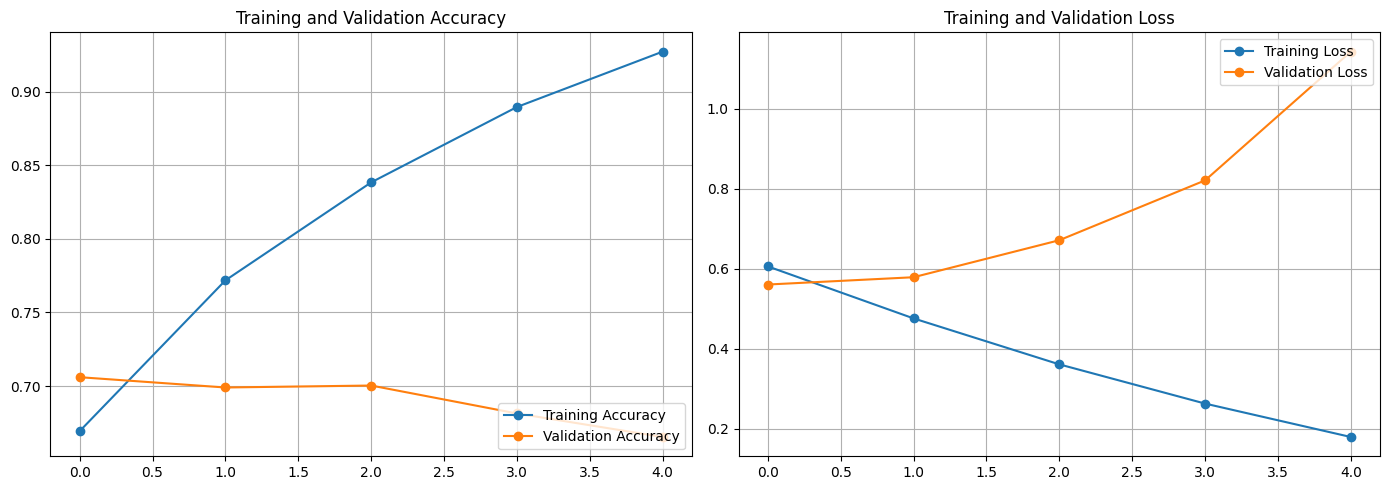

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
## PREDICTION (TEST SET)
y_pred_prob = model.predict(X_test_padded)
y_pred=y_pred_prob.argmax(axis=-1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


### • performance

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7200
Precision: 0.7295
Recall:    0.6993
F1 Score:  0.7141


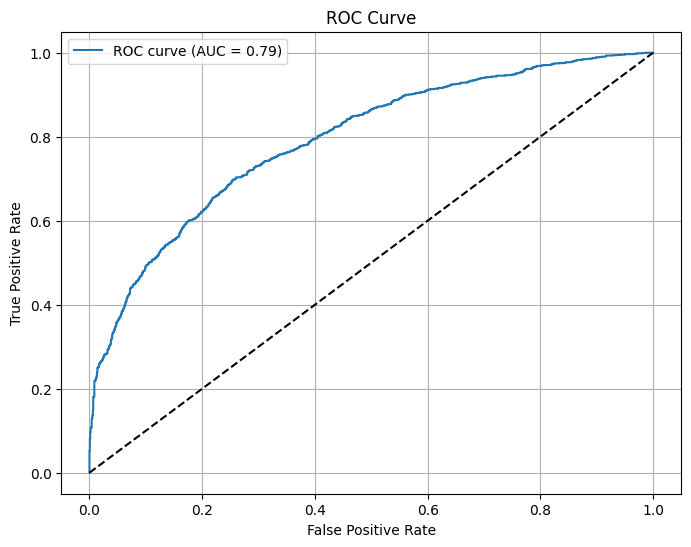

In [ ]:
## ROC CURVE

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

positive_probs = y_pred_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()



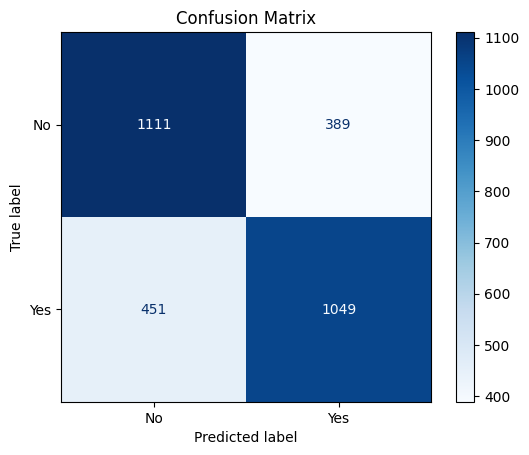

In [ ]:
## CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


###2.**BiLSTM with BioBert tokenizer**


In [ ]:
### MODEL

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(embedded)     # (batch_size, seq_len, hidden_dim*2)

        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1)  # (batch_size,)
            last_indices = (lengths - 1).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1)
            last_indices = last_indices.expand(-1, 1, lstm_out.size(2))  # (batch_size, 1, hidden_dim*2)
            last_hidden_state = lstm_out.gather(1, last_indices).squeeze(1)  # (batch_size, hidden_dim*2)
        else:
            last_hidden_state = lstm_out[:, -1, :]

        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        return out

vocab_size = len(tokenizer.vocab)
print(f"vocabulary size: {vocab_size}\n")

model = BiLSTMModel(vocab_size=vocab_size, embedding_dim=128, hidden_dim=256, output_dim=len(set(train_df["final_decision"])))
model.to(device)
print(model)


vocabulary size: 28996

BiLSTMModel(
  (embedding): Embedding(28996, 128)
  (lstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# SET TRAINING PARAMETERS
epochs = 50
initial_lr=1e-3
wd=1e-4   # weight_decay

optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=wd) # Adam
criterion = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, min_lr=1e-6, threshold=0.0001, verbose=True)
early_stopping = EarlyStopping(model=model, patience=6)


Epoch 1/50


Training: 100%|██████████| 718/718 [00:55<00:00, 13.01it/s]


Train loss: 0.6955 | Train acc: 0.5207


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 32.03it/s]


val loss: 0.6897 | val acc: 0.5417
save: Best results
LR: [0.001]

Epoch 2/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.10it/s]


Train loss: 0.6633 | Train acc: 0.5838


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 31.86it/s]


val loss: 0.5550 | val acc: 0.6960
save: Best results
LR: [0.001]

Epoch 3/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.07it/s]


Train loss: 0.5301 | Train acc: 0.7512


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 31.99it/s]


val loss: 0.4953 | val acc: 0.7664
save: Best results
LR: [0.001]

Epoch 4/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.09it/s]


Train loss: 0.4566 | Train acc: 0.7947


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 31.93it/s]


val loss: 0.3988 | val acc: 0.8232
save: Best results
LR: [0.001]

Epoch 5/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.08it/s]


Train loss: 0.3814 | Train acc: 0.8415


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 31.92it/s]


val loss: 0.3886 | val acc: 0.8274
save: Best results
LR: [0.001]

Epoch 6/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.08it/s]


Train loss: 0.3503 | Train acc: 0.8563


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 32.00it/s]


val loss: 0.3677 | val acc: 0.8417
save: Best results
LR: [0.001]

Epoch 7/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.09it/s]


Train loss: 0.3242 | Train acc: 0.8693


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 31.96it/s]


val loss: 0.3606 | val acc: 0.8454
save: Best results
LR: [0.001]

Epoch 8/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.10it/s]


Train loss: 0.2945 | Train acc: 0.8826


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 32.02it/s]


val loss: 0.3647 | val acc: 0.8479
LR: [0.001]
INFO: Early stopping counter 1 of 6

Epoch 9/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.09it/s]


Train loss: 0.2668 | Train acc: 0.8963


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 31.87it/s]


val loss: 0.3741 | val acc: 0.8365
LR: [0.001]
INFO: Early stopping counter 2 of 6

Epoch 10/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.10it/s]


Train loss: 0.2350 | Train acc: 0.9099


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 32.01it/s]


val loss: 0.3894 | val acc: 0.8343
LR: [0.001]
INFO: Early stopping counter 3 of 6

Epoch 11/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.10it/s]


Train loss: 0.2070 | Train acc: 0.9241


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 31.82it/s]


val loss: 0.4323 | val acc: 0.8346
LR: [0.0001]
INFO: Early stopping counter 4 of 6

Epoch 12/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.10it/s]


Train loss: 0.1318 | Train acc: 0.9595


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 31.97it/s]


val loss: 0.5508 | val acc: 0.8314
LR: [0.0001]
INFO: Early stopping counter 5 of 6

Epoch 13/50


Training: 100%|██████████| 718/718 [00:54<00:00, 13.11it/s]


Train loss: 0.1140 | Train acc: 0.9672


make predictions... : 100%|██████████| 127/127 [00:03<00:00, 31.96it/s]


val loss: 0.6040 | val acc: 0.8264
LR: [0.0001]
INFO: Early stopping counter 6 of 6
INFO: Early stopping
Early stopping
Model saved to LSTM__0.8454.pt.pt


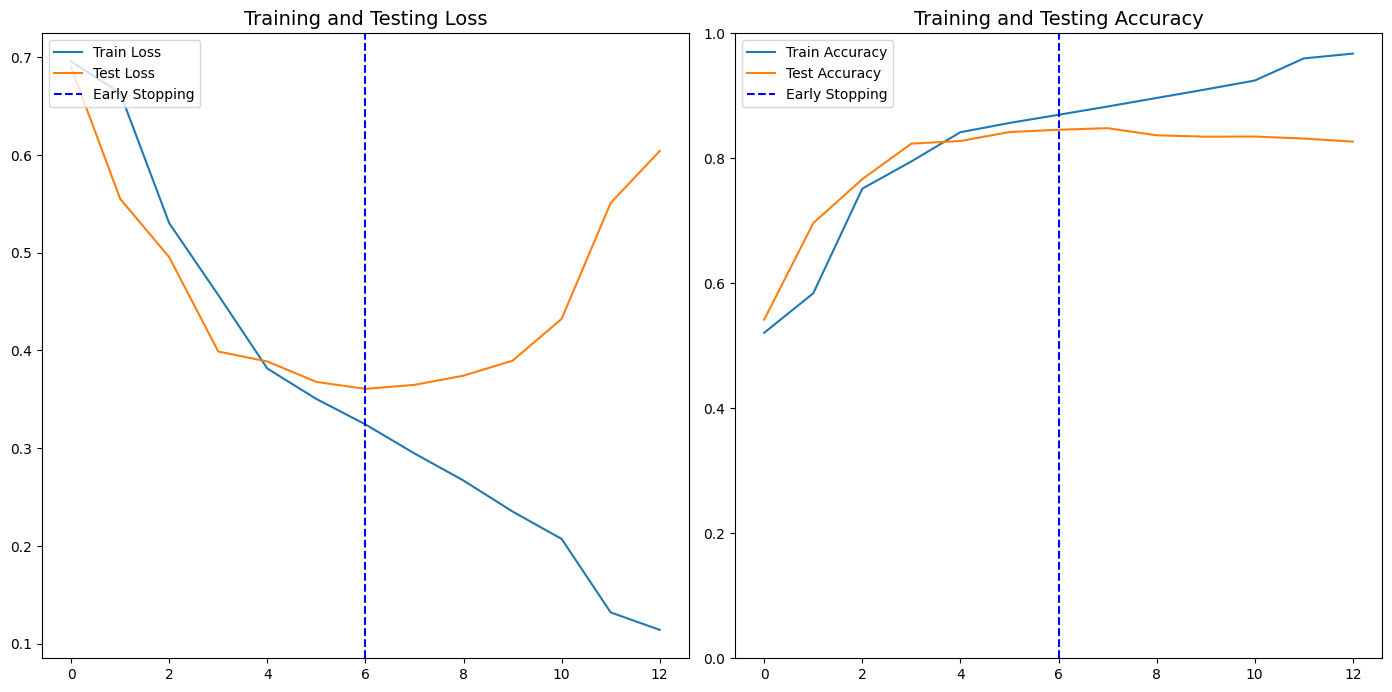

In [ ]:
## TRAINING
model_history, model_filename = fit(NUM_EPOCHS=epochs,
                    model=model,
                    train_data_loader=train_loader,
                    val_data_loader=val_loader,
                    scheduler=scheduler,
                    early_stopping=early_stopping,
                    save_dir="",
                    criterion=criterion,
                    optimizer=optimizer,
                    accuracy_fn=accuracy_fn,
                    device=device)
# training curves
plot_training_curves(model=model, history=model_history)

The dashed line shows the point (epoch 6) in which the model was saved due to the early stopping.

Indeed, going on with the epochs, overfitting occurred (the train loss continued to decrease, while the validation loss increased).

### • performance

In [ ]:
# PREDICTION (TEST SET)
y_test_scores, model_test_history = test(model=model,
                                        split='test',
                                        data_loader=test_loader,
                                        criterion=criterion,
                                        accuracy_fn=accuracy_fn,
                                        device=device)

# labels
probs = F.softmax(y_test_scores, dim=1)
y_pred = probs.argmax(dim=1)
y_true = test_dataset.tensors[2].long().squeeze()
print("\npredictions: ", y_pred)
print("real targets: ", y_true)

# metrics
metrics=calculate_metrics(y_pred, y_true, num_classes=2)
for metric, value in metrics.items():
    print(f'{metric}: {value:.4f}')



make predictions... : 100%|██████████| 94/94 [00:02<00:00, 32.02it/s]

test loss: 0.6028 | test acc: 0.8277

predictions:  tensor([0, 0, 1,  ..., 0, 1, 1])
real targets:  tensor([1, 0, 1,  ..., 0, 1, 1])
accuracy: 0.8277
precision: 0.8278
recall (sensitivity): 0.8277
f1_score: 0.8277
specificity: 0.8277


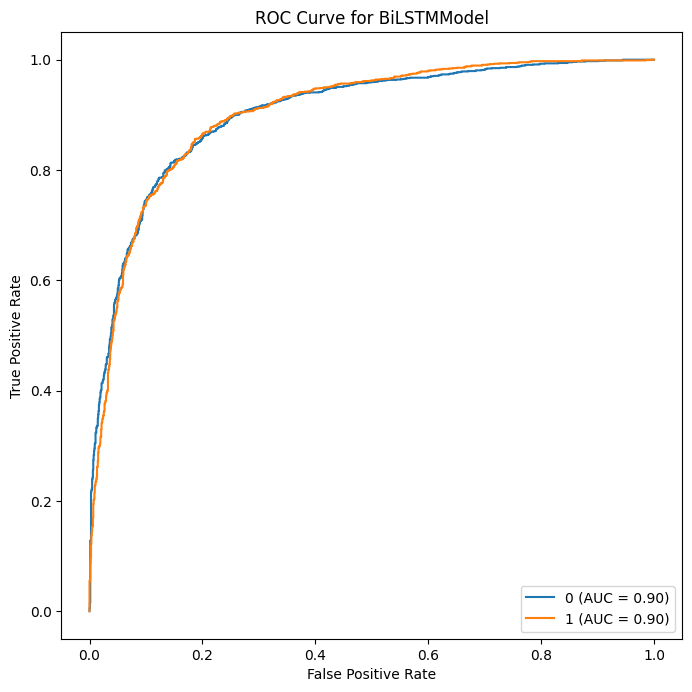

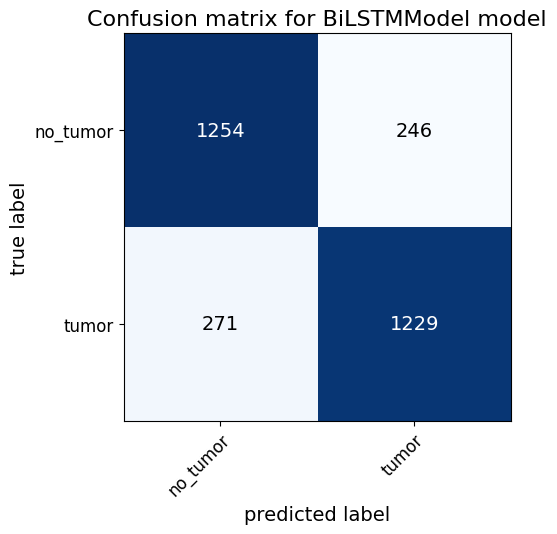

In [ ]:
class_names = {0:'no_tumor', 1:'tumor'}
num_class=len(class_names)

# ROC
plot_roc_curve(model=model,
               y_probs=probs,
               data_set=test_dataset,
               class_names=class_names)
#AUROC=AUROC(y_probs=average_probs, data_set=val_sag_dataset, num_class=num_class)
#print(f'AUROC: {AUROC}')

# confusion matrix
CM = confusion_matrix(model=model,
                    y_probs=probs,
                    data_set=test_dataset,
                    class_names=class_names,
                    normalize=False) # True: print the %

Now the model is able to classify correctly most of the samples.

Try to see if there are differences between the performance of the PQA-L samples, and PQA-A samples

In [ ]:
y_pred_np = y_pred.numpy()
y_true_np = y_true.numpy()

# separate predictions
mask_pqa_l = test_df["source"] == "pqa_l"
mask_pqa_a = test_df["source"] == "pqa_a"

y_pred_pqa_l = y_pred_np[mask_pqa_l.values]
y_true_pqa_l = y_true_np[mask_pqa_l.values]
y_pred_pqa_l = torch.tensor(y_pred_pqa_l)
y_true_pqa_l = torch.tensor(y_true_pqa_l)

y_pred_pqa_a = y_pred_np[mask_pqa_a.values]
y_true_pqa_a = y_true_np[mask_pqa_a.values]
y_pred_pqa_a = torch.tensor(y_pred_pqa_a)
y_true_pqa_a = torch.tensor(y_true_pqa_a)

# metrics
print("📊 Performance on PQA-L:")
metrics_l = calculate_metrics(y_pred_pqa_l, y_true_pqa_l, num_classes=2)
for metric, value in metrics_l.items():
    print(f"{metric}: {value:.4f}")

print("\n📊 Performance on PQA-A:")
metrics_a = calculate_metrics(y_pred_pqa_a, y_true_pqa_a, num_classes=2)
for metric, value in metrics_a.items():
    print(f"{metric}: {value:.4f}")

📊 Performance su PQA-L:
accuracy: 0.8900
precision: 0.8864
recall (sensitivity): 0.8888
f1_score: 0.8875
specificity: 0.8888

📊 Performance su PQA-A:
accuracy: 0.8255
precision: 0.8256
recall (sensitivity): 0.8255
f1_score: 0.8255
specificity: 0.8255


As we can see there are not big differences with the PQA-L (which is the real one) that performs a little better
=> Good news!!

###3.**BIOBERT**

We report only the TL results, since they erre the best one

In [ ]:
## MODEL

model_name="dmis-lab/biobert-base-cased-v1.1"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
)
model.to(device)
print(model)


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

This warning is expected, since BioBERT was originally pre-trained as a feature extractor without a classification head. Therefore, when loading the model for a classification task, the final classifier layer (classifier.weight and classifier.bias) is randomly initialized and needs to be fine-tuned.

In [ ]:
# 1. FINE-TUNING  -->  78% accuracy
#for name, param in model.bert.named_parameters():
#    param.requires_grad = False # freeze all the backbone layers


# 2. RETRAINING  -->  87% accuracy
#for name, param in model.bert.named_parameters():
#    param.requires_grad = True # freeze all the backbone layers.


# 3. TRANSFER LEARNING  --> 93% accuracy
for name, param in model.named_parameters():
    if "classifier" in name or "encoder.layer.11" in name or "encoder.layer.10" in name or "encoder.layer.9" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n Trainable params: {trainable} / {total} ({100 * trainable / total:.2f}%)")


bert.embeddings.word_embeddings.weight - requires_grad: False
bert.embeddings.position_embeddings.weight - requires_grad: False
bert.embeddings.token_type_embeddings.weight - requires_grad: False
bert.embeddings.LayerNorm.weight - requires_grad: False
bert.embeddings.LayerNorm.bias - requires_grad: False
bert.encoder.layer.0.attention.self.query.weight - requires_grad: False
bert.encoder.layer.0.attention.self.query.bias - requires_grad: False
bert.encoder.layer.0.attention.self.key.weight - requires_grad: False
bert.encoder.layer.0.attention.self.key.bias - requires_grad: False
bert.encoder.layer.0.attention.self.value.weight - requires_grad: False
bert.encoder.layer.0.attention.self.value.bias - requires_grad: False
bert.encoder.layer.0.attention.output.dense.weight - requires_grad: False
bert.encoder.layer.0.attention.output.dense.bias - requires_grad: False
bert.encoder.layer.0.attention.output.LayerNorm.weight - requires_grad: False
bert.encoder.layer.0.attention.output.LayerNorm.

In [ ]:
# SET TRAINING PARAMETERS
epochs = 50
initial_lr=1e-4 # decrease the LR
wd=1e-4   # weight_decay


optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=wd) # AdamW
criterion = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, min_lr=1e-6, threshold=0.0001, verbose=True)
early_stopping = EarlyStopping(model=model, patience=5)


Epoch 1/50


Training: 100%|██████████| 718/718 [10:58<00:00,  1.09it/s]


Train loss: 0.3002 | Train acc: 0.8675


Evaluation...: 100%|██████████| 127/127 [01:03<00:00,  2.00it/s]


val loss: 0.2046 | val acc: 0.9173
save: Best results
LR: [0.0001]

Epoch 2/50


Training: 100%|██████████| 718/718 [10:59<00:00,  1.09it/s]


Train loss: 0.2035 | Train acc: 0.9182


Evaluation...: 100%|██████████| 127/127 [01:03<00:00,  2.00it/s]


val loss: 0.1942 | val acc: 0.9170
save: Best results
LR: [0.0001]

Epoch 3/50


Training: 100%|██████████| 718/718 [10:59<00:00,  1.09it/s]


Train loss: 0.1648 | Train acc: 0.9339


Evaluation...: 100%|██████████| 127/127 [01:03<00:00,  2.00it/s]


val loss: 0.2159 | val acc: 0.9198
LR: [0.0001]
INFO: Early stopping counter 1 of 5

Epoch 4/50


Training: 100%|██████████| 718/718 [10:59<00:00,  1.09it/s]


Train loss: 0.1327 | Train acc: 0.9485


Evaluation...: 100%|██████████| 127/127 [01:03<00:00,  2.00it/s]


val loss: 0.2293 | val acc: 0.9180
LR: [0.0001]
INFO: Early stopping counter 2 of 5

Epoch 5/50


Training: 100%|██████████| 718/718 [11:00<00:00,  1.09it/s]


Train loss: 0.1060 | Train acc: 0.9589


Evaluation...: 100%|██████████| 127/127 [01:03<00:00,  2.00it/s]


val loss: 0.2232 | val acc: 0.9252
LR: [0.0001]
INFO: Early stopping counter 3 of 5

Epoch 6/50


Training: 100%|██████████| 718/718 [11:00<00:00,  1.09it/s]


Train loss: 0.0856 | Train acc: 0.9684


Evaluation...: 100%|██████████| 127/127 [01:03<00:00,  2.00it/s]


val loss: 0.2439 | val acc: 0.9242
LR: [1e-05]
INFO: Early stopping counter 4 of 5

Epoch 7/50


Training: 100%|██████████| 718/718 [11:00<00:00,  1.09it/s]


Train loss: 0.0407 | Train acc: 0.9866


Evaluation...: 100%|██████████| 127/127 [01:03<00:00,  2.00it/s]


val loss: 0.2636 | val acc: 0.9237
LR: [1e-05]
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Early stopping
Model saved to LSTM__0.9170.pt.pt


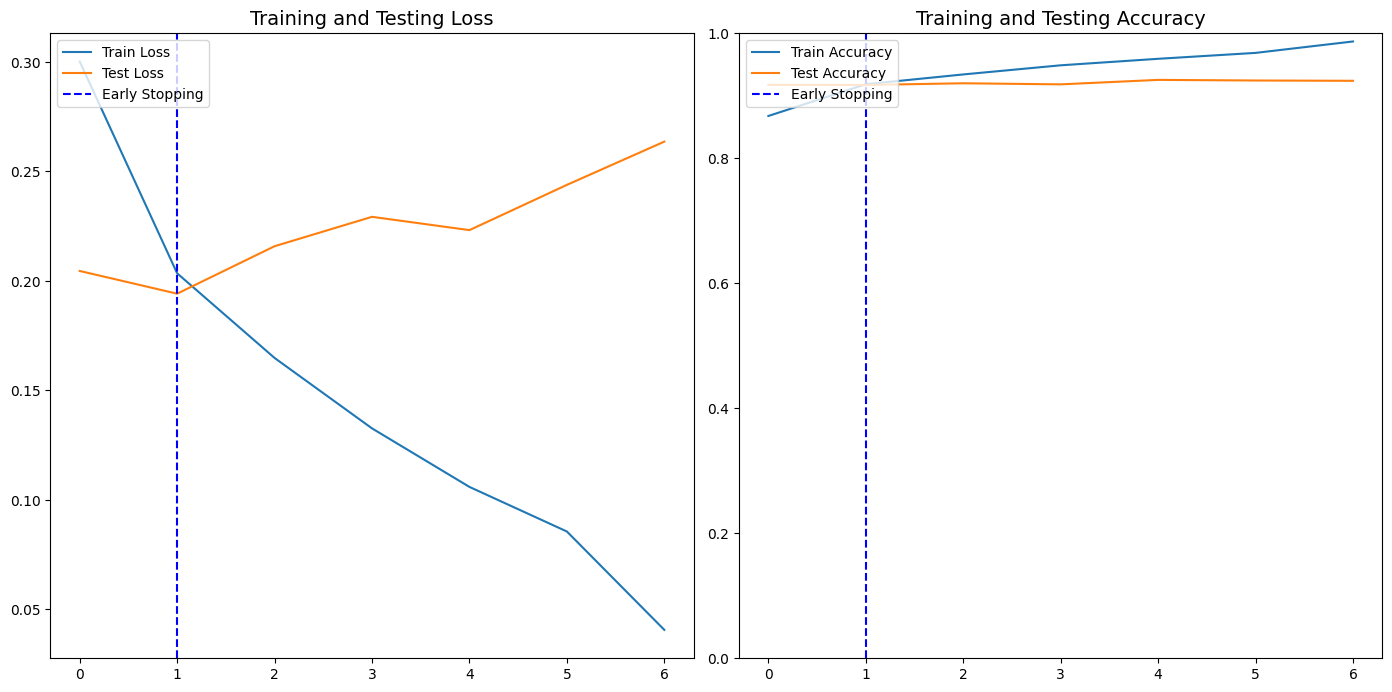

In [ ]:
model_history, model_filename = fit(NUM_EPOCHS=epochs,
                    model=model,
                    train_data_loader=train_loader,
                    val_data_loader=val_loader,
                    scheduler=scheduler,
                    early_stopping=early_stopping,
                    save_dir="",
                    criterion=criterion,
                    optimizer=optimizer,
                    accuracy_fn=accuracy_fn,
                    device=device)
# training curves
plot_training_curves(model=model, history=model_history)

### • performance

In [ ]:
# PREDICTION (test set)
y_test_scores, model_test_history = test(model=model,
                                        split='test',
                                        data_loader=test_loader,
                                        criterion=criterion,
                                        accuracy_fn=accuracy_fn,
                                        device=device)

# labels
probs = F.softmax(y_test_scores, dim=1)
y_pred = probs.argmax(dim=1)
y_true = torch.tensor([test_dataset[i]["labels"] for i in range(len(test_dataset))]).long()
#y_true = test_dataset.tensors[2].long().squeeze()
print("\npredictions: ", y_pred)
print("real targets: ", y_true)

# metrics
metrics=calculate_metrics(y_pred, y_true, num_classes=2)
for metric, value in metrics.items():
    print(f'{metric}: {value:.4f}')



Evaluation...: 100%|██████████| 94/94 [00:47<00:00,  2.00it/s]

test loss: 0.2757 | test acc: 0.9293

predictions:  tensor([1, 0, 1,  ..., 0, 1, 1])
real targets:  tensor([1, 0, 1,  ..., 0, 1, 1])
accuracy: 0.9293
precision: 0.9294
recall (sensitivity): 0.9293
f1_score: 0.9293
specificity: 0.9293


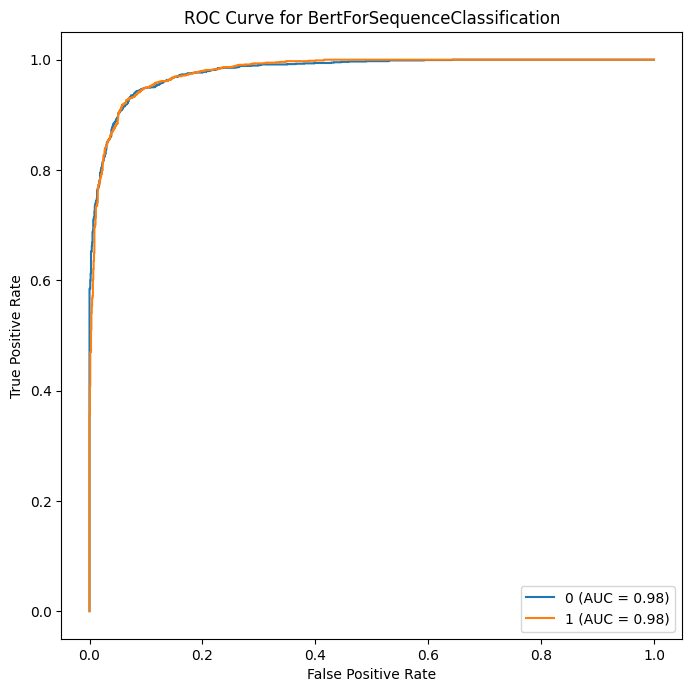

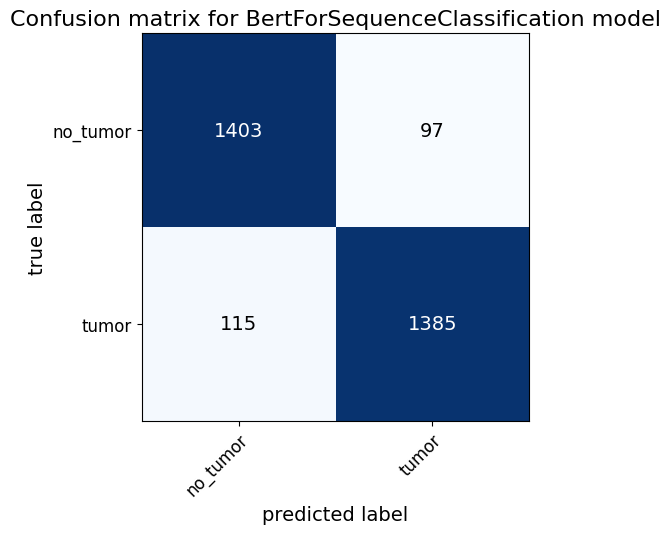

In [ ]:
class_names = {0:'no_tumor', 1:'tumor'}
num_class=len(class_names)

# ROC
plot_roc_curve(model=model,
               y_probs=probs,
               data_set=test_dataset,
               class_names=class_names)
#AUROC=AUROC(y_probs=average_probs, data_set=val_sag_dataset, num_class=num_class)
#print(f'AUROC: {AUROC}')

# confusion matrix
CM = confusion_matrix(model=model,
                    y_probs=probs,
                    data_set=test_dataset,
                    class_names=class_names,
                    normalize=False) # True: print the %

In [ ]:
# PERFORMANCE FOR EACH DATASET
y_pred_np = y_pred.numpy()
y_true_np = y_true.numpy()

mask_pqa_l = test_df["source"] == "pqa_l"
mask_pqa_a = test_df["source"] == "pqa_a"
y_pred_pqa_l = y_pred_np[mask_pqa_l.values]
y_true_pqa_l = y_true_np[mask_pqa_l.values]
y_pred_pqa_l = torch.tensor(y_pred_pqa_l)
y_true_pqa_l = torch.tensor(y_true_pqa_l)

y_pred_pqa_a = y_pred_np[mask_pqa_a.values]
y_true_pqa_a = y_true_np[mask_pqa_a.values]
y_pred_pqa_a = torch.tensor(y_pred_pqa_a)
y_true_pqa_a = torch.tensor(y_true_pqa_a)

# metrics
print("📊 Performance PQA-L:")
metrics_l = calculate_metrics(y_pred_pqa_l, y_true_pqa_l, num_classes=2)
for metric, value in metrics_l.items():
    print(f"{metric}: {value:.4f}")

print("\n📊 Performance PQA-A:")
metrics_a = calculate_metrics(y_pred_pqa_a, y_true_pqa_a, num_classes=2)
for metric, value in metrics_a.items():
    print(f"{metric}: {value:.4f}")



📊 Performance su PQA-L:
accuracy: 0.8600
precision: 0.8600
recall (sensitivity): 0.8695
f1_score: 0.8591
specificity: 0.8695

📊 Performance su PQA-A:
accuracy: 0.9317
precision: 0.9318
recall (sensitivity): 0.9317
f1_score: 0.9317
specificity: 0.9317


‼️ The performance are a little bit higher for the PQA-A dataset
(maybe PQA-A samples are more simple because are generated in an autonomous way. Ex: the question is generated as the interrogative version of the answer)

### Conclusion

The results clearly show that both the quality of preprocessing and the choice of model architecture significantly impact performance.
key results:

*   Traditional preprocessing alone is not sufficient to capture the complexity of biomedical language.
*   When using both tokenization and pretrained contextual embeddings from BioBERT, performance improves even further, demonstrating the importance of domain-specific language representations.


These findings highlight that leveraging pretrained models like BioBERT is essential for biomedical NLP tasks.
Moreover, finding the right balance between generalization and task-specific adaptation is key.
In this context, transfer learning offers the best trade-off, achieving the highest performance in our experiments.

## 2️⃣ Q&A TASK

In this section, we will fine-tune the base [LLaMA2-7B](https://huggingface.co/meta-llama/Llama-2-7b-hf) model from Hugging Face on the PubMedQA dataset. The goal is to train the model to generate both a final decision (“yes” or “no”) and a long-form explanation for each question, improving its ability to provide accurate and well-structured answers to medical questions.

Before fine-tuning, we will evaluate the base model using zero-shot, one-shot, and few-shot prompting approaches. This will help establish baseline performance and provide insight into how well the model handles the task without task-specific training.

We'll test all the LlaMA models on the PubMedQA dataset using several evaluation metrics:
  - Semantic metrics such as:
	  -	ROUGE
	  -	BERTScore (precision, recall, and F1)
  -	Classification metrics

These metrics will give us a well-rounded view of how both models perform.<br>
For the ROUGE and BERTScore evaluation, we'll use the Hugging Face `evaluate` library.


### • Additional installations and imports

In [ ]:
!pip install -U \
  transformers \
  accelerate \
  trl \
  peft \
  bitsandbytes \
  evaluate \
  rouge_score \
  bert_score

In [ ]:
import evaluate
from transformers import  AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig, TrainingArguments, EarlyStoppingCallback
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, SFTConfig
from accelerate import Accelerator
from sklearn.metrics import classification_report
from huggingface_hub import notebook_login
from IPython.display import display, clear_output

### • Custom preprocessing

For this task, we chose to use the `pqa_artificial` dataset because it includes labeled data and contains more than 1,000 samples, which makes it possible to extract a balanced subset of "yes" and "no" answers for fine-tuning.

The preprocessing steps involve:
- Removing unnecessary fields
- Sampling 4,000 “yes” and 4,000 “no” answers to keep the classes balanced and have enough data without making training take too long.
- Flattening the context field for easier input formatting
- Combining the final_decision and long_answer into a full answer to better guide the model generated responses.
- Formatting each example into an instruction-style prompt

The processed data is then split into training and evaluation sets, and converted into Hugging Face `Dataset` objects for model training.

In [ ]:
#load dataset
dataset = pd.read_parquet("/content/drive/MyDrive/NLP/Assignment/PQA-A.parquet")

In [ ]:
def preprocess_df(df):
    #drop pubid
    df = df.drop(columns=['pubid'])

    #Keep only relevant field in the 'context' dict (and string)
    df['context'] = df['context'].apply(
        lambda x: ' '.join(x['contexts']) if isinstance(x, dict) and 'contexts' in x else str(x)
    )
    #Extract 4k rows with 'final_answer' 'yes' and 4k rows 'no and concatenate it
    df_yes = df[df['final_decision'] == 'yes'].sample(n=4000, random_state=42)
    df_no = df[df['final_decision'] == 'no'].sample(n=4000, random_state=42)
    df = pd.concat([df_yes, df_no])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    df['question'] = df['question'].apply(lambda x: str(x))
    #Combine 'final_answer' and 'long_answer' as 'answer'
    df['answer'] = df['final_decision'] + ', ' + df['long_answer']
    df['answer'] = df['answer'].apply(lambda x: str(x))
    #Drop long_answer and final_decision
    df = df.drop(columns=['long_answer'])

    return df

dataset = preprocess_df(dataset)

To tune the model using the SFTTrainer, we need to create a 'text' column in our dataset that contains the formatted prompts. This column should include the complete input text as it will be presented to the model during training.

In [ ]:
def formatting_prompts_func(row):
    return (
        f"### Instruction:\n"
        f"You are a medical expert. Based on the following context, answer the question with 'Yes' or 'No', followed by a clear and accurate explanation.\n"
        f"### Context:\n{row['context']}\n"
        f"### Question:\n{row['question']}\n"
        f"### Answer:\n{row['answer']}"
    )

dataset['text'] = dataset.apply(formatting_prompts_func, axis=1)

We chose this specific prompt format—based on the [Stanford Alpaca](https://github.com/tatsu-lab/stanford_alpaca?tab=readme-ov-file#data-release) style—because it aligns well with how LLaMA2 models are typically fine-tuned. The structured ### Instruction, ### Context, ### Question, and ### Answer format provides clear task framing, which should help the model better understand its role and expected output.<br>
As we can see from the prompt, we chose to have the model give both the `final answer` (“yes” or “no”) and an explanation (`long_answer`). That's because, when we only asked for an explanation, the model often gave vague or general responses and didn't clearly answer the question. By asking for a direct “yes” or “no” first, we made sure the model stayed focused and gave clearer, more useful answers.

In [ ]:
train_dataset, eval_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
len(train_dataset), len(eval_dataset)

(6400, 1600)

In [ ]:
# Convert pandas Series to Hugging Face Dataset objects
train_dataset_hf = Dataset.from_pandas(train_dataset)
eval_dataset_hf = Dataset.from_pandas(eval_dataset)

All processing steps are done, we can continue.

### • Load base model

First of all we need to load the base LLaMa model from Hugging Face.<br>
To access the official LLaMA models from Meta, it's needed a personal access token, which can be generated at:<br>
https://huggingface.co/

In [ ]:
notebook_login()

We can now load the model from Hugging Face with weight quantization to reduce GPU usage. In simple terms, quantization means converting the model's 32-bit weights into smaller 4-bit numbers, which makes the model use less memory and run more efficiently.

In [ ]:
def load_model_and_tokenizer(model_name):

  quantization_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_compute_dtype=torch.bfloat16,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_use_double_quant=False,
  )

  device_index = Accelerator().process_index
  device_map = {"": device_index}

  #Import the model from hf with quantization config
  model = AutoModelForCausalLM.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      device_map=device_map,
      quantization_config=quantization_config
  )

  #Import also LLaMa tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
  tokenizer.pad_token = tokenizer.eos_token
  tokenizer.padding_side = "right"
  return model, tokenizer

model_name = "meta-llama/Llama-2-7b-hf"
base_model, base_tokenizer = load_model_and_tokenizer(model_name)

### • Testing set up

Before evaluating the performance we need to define some helper functions to perform inference on our model and compute all the needed metrics.

In [ ]:
# Formats a prompt for n-shot learning by combining several example Q&A pairs
def n_shot_formatting_prompts(new_example, examples=[]):
    instruction = (
        "### Instruction:\n"
        "You are a medical expert. Based on the following context, answer the question with 'Yes' or 'No', followed by a clear and accurate explanation.\n"
    )
    body = ""

    for i, ex in enumerate(examples, 1):
        body += (
            f"\n### Example {i}:\n"
            f"### Context:\n{ex['context']}\n"
            f"### Question:\n{ex['question']}\n"
            f"### Answer:\n{ex['answer']}\n\n"
        )

    # Append the test instance
    body += (
        f"\n###End of examples\n"
        f"### Now answer the following:\n"
        f"### Context:\n{new_example['context']}\n"
        f"### Question:\n{new_example['question']}\n"
        f"### Answer:\n"
    )

    return instruction + body

In [ ]:
# This function generates model responses for a given dataset of medical questions.
# It supports zero-/few-shot prompting using optional example prompts.
# For each question (and optional context), it builds a prompt and uses a text-generation pipeline
# to generate an answer from the model. It returns lists of questions, model predictions, and references.
def generate_responses(dataset, model, tokenizer, examples=[]):
    preds = []
    refs = []
    questions_out = []

    questions = dataset["question"].tolist()
    contexts = dataset["context"].tolist() if use_context else [""] * len(dataset)
    references = dataset["answer"].apply(str.strip).tolist()

    generation_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device_map="auto"
    )

    for i, (q, c, ref) in enumerate(zip(questions, contexts, references), 1):
        print(f"Processing example {i}/{len(questions)}...")

        if len(examples) != 0:
            prompt = n_shot_formatting_prompts({"context": c, "question": q}, examples)
        else:
            prompt = (
                "### Instruction:\n"
                f"You are a medical expert. Based on the following context, answer the question with 'Yes' or 'No', followed by a clear and accurate explanation.\n"
                f"### Context:{c}\n"
                f"### Question:{q}\n"
                "### Answer:"
            )

        max_new_tokens = 128

        response = generation_pipeline(
            prompt,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            repetition_penalty=1.1,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )[0]['generated_text']

        answer = response[len(prompt):].strip()
        preds.append(answer)
        refs.append(ref)
        questions_out.append(q)
        torch.cuda.empty_cache()

        clear_output(wait=True)  # Clear stdout after each iteration

    return questions_out, preds, refs

In [ ]:
#Extracts 'yes' or 'no' from the start of a given answer string.
def extract_label(text):
    text = text.strip().lower()
    if text.startswith("yes"):
        return "yes"
    elif text.startswith("no"):
        return "no"
    return None

#Computes all classification metrics from a list of predictions/references and return a dict with all results.
def compute_class_report(preds, refs):
    pred_labels = [extract_label(p) for p in preds]
    ref_labels = [extract_label(r) for r in refs]

    # Filter out any samples where label extraction failed
    valid_indices = [i for i, (p, r) in enumerate(zip(pred_labels, ref_labels)) if p in {"yes", "no"} and r in {"yes", "no"}]
    discarded_answers = len(preds) - len(valid_indices)
    filtered_preds = [pred_labels[i] for i in valid_indices]
    filtered_refs = [ref_labels[i] for i in valid_indices]

    if not filtered_preds:
        return {"classification_accuracy": None}

    report_dict = classification_report(filtered_refs, filtered_preds, output_dict=True)

    return {
    "classification_report": report_dict,
    "number_of_answers_without_labels": discarded_answers
    }

In [ ]:
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

def evaluate_all_metrics(predictions, references):
    results = {}

    # ROUGE
    rouge_result = rouge.compute(predictions=predictions, references=references)
    results.update(rouge_result)

    # BERTScore
    bert_result = bertscore.compute(predictions=predictions, references=references, lang="en")
    bert_means = {f"bertscore_{k}": np.mean(v) for k, v in bert_result.items() if k != "hashcode"}
    results.update(bert_means)

    #Classification report
    accuracy = compute_class_report(predictions, references)
    results.update(accuracy)

    return results

In [ ]:
#Pretty print the evaluation results
def print_metrics(metrics: dict, title: str = "Evaluation Metrics"):
    def print_line(char='-', width=60):
        print(char * width)

    print(f"\n=== {title} ===")
    print(f"{'Metric':<40} {'Value':>15}")
    print_line()

    for k, v in metrics.items():
        if isinstance(v, dict) and k == "classification_report":
            print(f"{k}:")
            print_classification_report(v)
        elif isinstance(v, (float, int)):
            print(f"{k:<40} {v:>15.4f}")
        else:
            print(f"{k:<40} {str(v):>15}")
    print_line()
    torch.cuda.empty_cache()


def print_classification_report(report: dict):
    labels = [label for label in report if label not in ("accuracy", "macro avg", "weighted avg")]
    specials = [k for k in ("accuracy", "macro avg", "weighted avg") if k in report]

    header = f"{'Label':<10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}"
    print(header)
    print("-" * len(header))

    def print_row(label, scores):
        precision = scores.get("precision", 0.0)
        recall = scores.get("recall", 0.0)
        f1 = scores.get("f1-score", 0.0)
        support = scores.get("support", 0.0)
        print(f"{label:<10} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10.0f}")

    for label in labels + specials:
        if label == "accuracy":
            print(f"\n{'Accuracy':<10} {report[label]:>10.4f}")
        else:
            print_row(label, report[label])

### • zero-shot

We can now test the base model without showing any examples of responses.

Due to time constraints, we'll downsample the evaluation dataset to 100 samples, which should still give us a good insight into the performance of both models.

In [ ]:
#down sample the eval set
eval_dataset_2 = eval_dataset.sample(n=100, random_state=42).reset_index(drop=True)

In [ ]:
#let's put the model in eval mode for better results
base_model.eval()

b_quests, b_preds, b_refs = generate_responses(eval_dataset_2, base_model, base_tokenizer)
base_metrics = evaluate_all_metrics(b_preds, b_refs)

In [ ]:
#print results
print_metrics(base_metrics, "Base Model Evaluation Metrics")


=== Base Model Evaluation Metrics ===
Metric                                             Value
------------------------------------------------------------
rouge1                                            0.0984
rouge2                                            0.0386
rougeL                                            0.0756
rougeLsum                                         0.0770
bertscore_precision                               0.7689
bertscore_recall                                  0.8440
bertscore_f1                                      0.8039
classification_report:
Label       Precision     Recall   F1-Score    Support
------------------------------------------------------
no             0.0000     0.0000     0.0000         29
yes            0.5735     1.0000     0.7290         39

Accuracy       0.5735
macro avg      0.2868     0.5000     0.3645         68
weighted avg     0.3289     0.5735     0.4181         68
number_of_answers_without_labels                 32.0000
---------

The base model seems to understand the meaning of the text fairly well (good BERTScore), but it doesn't match the exact words of the reference very closely (low ROUGE scores).

For classification, the model predicts "yes" almost all the time. It gets all the "yes" answers right, but misses every "no" — which brings the overall accuracy to about 57%.

Also, 32 answers were skipped because they didn't have labels. An indication that the model struggled to follow the prompt correctly.

### • one-shot

Now let's update the prompt to include a single example question-answer pair—a one-shot approach. This can help the model better understand the task by providing a concrete example of the expected input and output.

Luckily, our inference function already supports this. We simply need to pass in the example, and it will automatically format the prompt accordingly.

In [ ]:
#sample one example from the train_set
one_shot_example = train_dataset.sample(n=1, random_state=42).to_dict(orient='records')

one_shot_quests, one_shot_preds, one_shot_refs = generate_responses(eval_dataset_2, base_model, base_tokenizer,one_shot_exampple)
one_shot_metrics = evaluate_all_metrics(one_shot_preds, one_shot_refs)

In [ ]:
print_metrics(one_shot_metrics, "One shot Model Evaluation Metrics")


=== One shot Model Evaluation Metrics ===
Metric                                             Value
------------------------------------------------------------
rouge1                                            0.3290
rouge2                                            0.1364
rougeL                                            0.2625
rougeLsum                                         0.2636
bertscore_precision                               0.9073
bertscore_recall                                  0.8867
bertscore_f1                                      0.8966
classification_report:
Label       Precision     Recall   F1-Score    Support
------------------------------------------------------
no             1.0000     0.3137     0.4776         51
yes            0.5833     1.0000     0.7368         49

Accuracy       0.6500
macro avg      0.7917     0.6569     0.6072        100
weighted avg     0.7958     0.6500     0.6046        100
number_of_answers_without_labels                  0.0000
-----

After incorporating a single example into the prompt (one-shot setting), the model showed improvement in understanding the task structure. It achieved strong semantic similarity scores with higher BERTscores, indicating good alignment with the reference answers.

However, classification performance was mixed. While the model had perfect precision for the "no" class, its recall was low (0.3137), meaning it missed many correct "no" answers. Conversely, it performed better on the "yes" class with high recall (1.0) but lower precision (0.5833). Overall accuracy was **65%**, suggesting room for improvement.

This result shows that even a single example helps guide the model, though fine-tuning is likely needed to improve consistency and class balance.

### • few-shot

Now let's try a few-shot approach by including 5 example question-answer pairs in the prompt. This method provides the model with more context about the expected input-output format and the reasoning style required for the task.

By giving multiple examples, we aim to further improve the model's ability to generate accurate final answers and well-structured explanations.

In [ ]:
#few shot
few_shot_examples = train_dataset.sample(n=5, random_state=42).to_dict(orient='records')

few_shot_quests, few_shot_preds, few_shot_refs = generate_responses(eval_dataset_2, base_model, base_tokenizer, few_shot_examples)
few_shot_metrics = evaluate_all_metrics(few_shot_preds, few_shot_refs)

In [ ]:
print_metrics(few_shot_metrics, "Few shot Model Evaluation Metrics")


=== Few shot Model Evaluation Metrics ===
Metric                                             Value
------------------------------------------------------------
rouge1                                            0.3719
rouge2                                            0.1591
rougeL                                            0.3040
rougeLsum                                         0.3063
bertscore_precision                               0.9021
bertscore_recall                                  0.8892
bertscore_f1                                      0.8954
classification_report:
Label       Precision     Recall   F1-Score    Support
------------------------------------------------------
no             0.9149     0.8431     0.8776         51
yes            0.8491     0.9184     0.8824         49

Accuracy       0.8800
macro avg      0.8820     0.8808     0.8800        100
weighted avg     0.8826     0.8800     0.8799        100
number_of_answers_without_labels                  0.0000
-----

Using a few-shot prompt with 5 example question-answer pairs significantly improved the model's performance.

The BERTScores remained strong, and ROUGE scores increased, indicating better overlap and structure in the generated answers.

Classification metrics showed a clear improvement:
- The model achieved a high accuracy of 88%.
- Both "yes" and "no" classes were predicted more reliably, with higher F1-scores.

These results highlight that providing multiple examples helps the model generalize better and produce more accurate and consistent outputs.

### • fine-tuning

Now that the few-shot approach gave us better results, we'll take it a step further and fine-tune the model on the PubMedQA dataset.

This should help the model give even more accurate answers and better explanations.

To better manage GPU usage, we use **LoRA** (Low-Rank Adaptation), a parameter-efficient fine-tuning (**PEFT**) technique. LoRA works by "freezing" most of the original model's weights and updating only a small number of additional parameters. This reduces both memory and compute requirements during training.

We'll also use the `SFTTrainer` from the `trl` library, which integrates well with LoRA and simplifies the fine-tuning process.

In [ ]:
lora_configs = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias='none',
    task_type='CAUSAL_LM',
)

#Trainer configuration
training_args = SFTConfig(
    output_dir="/content/drive/MyDrive/NLP/Assignment/train-checkpoints",
    logging_steps=200,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=400,
    load_best_model_at_end=True,
    run_name="llama2-big-run",
    max_seq_length=512,
    report_to=[],
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 2,
    gradient_checkpointing = False,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    num_train_epochs=2,
    bf16=True,
    packing=False,
    save_total_limit=1,
    dataset_text_field='text',
    metric_for_best_model="eval_loss",
)

trainer = SFTTrainer(
    model=base_model,
    train_dataset=train_dataset_hf,
    eval_dataset=eval_dataset_hf,
    args=training_args,
    peft_config=lora_configs,
    formatting_func=None,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


Now that all the configuration are defined we can start the training process.

In [ ]:
save_path = "/content/drive/MyDrive/NLP/Assignment/adapter-weights"
trainer.train()
trainer.save_model(save_path)

Now that we have fine-tuned the model, we can save it to disk. After that, we'll load the saved model and run inference to check if its performance has improved.

In [ ]:
# Load a fresh base model (not quantized)
fresh_model = AutoModelForCausalLM.from_pretrained(model_name)
# Load adapter on top of base
peft_model = PeftModel.from_pretrained(fresh_model, save_path)
#Merge the adapter and the original LLaMa model
merged_model = peft_model.merge_and_unload()
#Save the fine-tuned model (and tokenizer)
merged_path = "/content/drive/MyDrive/NLP/Assignment/final-model"
merged_model.save_pretrained(merged_path)
base_tokenizer.save_pretrained(merged_path)

('/content/drive/MyDrive/NLP/Assignment/final-model/tokenizer_config.json',
 '/content/drive/MyDrive/NLP/Assignment/final-model/special_tokens_map.json',
 '/content/drive/MyDrive/NLP/Assignment/final-model/tokenizer.model',
 '/content/drive/MyDrive/NLP/Assignment/final-model/added_tokens.json')

In [ ]:
#Clean the environment before reloading the two models
del fresh_model
del base_model
del base_tokenizer
torch.cuda.empty_cache()

In [ ]:
#Reload a fresh base model
base_model, base_tokenizer = load_model_and_tokenizer(model_name)
#Load the fine-tuned model from Hugging Face Hub (instead of loading from local drive)
fine_tuned_model_name = "NMantegazza/PubMedLLaMa"
tuned_model, tuned_tokenizer = load_model_and_tokenizer(fine_tuned_model_name)

Now we can evaluate the fine-tuned model using the same metrics as before to compare its performance with the zero-, one-, and few-shot results.

In [ ]:
tuned_model.eval()
#test the tuned model
t_quests, t_preds, t_refs = generate_responses(eval_dataset_2, tuned_model, tuned_tokenizer)
tuned_metrics = evaluate_all_metrics(t_preds, t_refs)

In [ ]:
#Print results
print_metrics(tuned_metrics, "Tuned Model Evaluation Metrics")


=== Tuned Model Evaluation Metrics ===
Metric                                             Value
------------------------------------------------------------
rouge1                                            0.3875
rouge2                                            0.1784
rougeL                                            0.3213
rougeLsum                                         0.3219
bertscore_precision                               0.9228
bertscore_recall                                  0.8949
bertscore_f1                                      0.9085
classification_report:
Label       Precision     Recall   F1-Score    Support
------------------------------------------------------
no             0.8750     0.9608     0.9159         51
yes            0.9545     0.8571     0.9032         49

Accuracy       0.9100
macro avg      0.9148     0.9090     0.9096        100
weighted avg     0.9140     0.9100     0.9097        100
number_of_answers_without_labels                  0.0000
--------

The fine-tuned model shows some improvements across all metrics compared to previous approaches.

- ROUGE scores increased slightly, with ROUGE-1 reaching, indicating a modest improvement in overlap with reference answers.
- BERTScore F1 also saw a small increase, suggesting the model better captures semantic similarity.
- Finally, classification accuracy improved to 91%.
  
Overall, the fine-tuning process slightly improved the model's performance across all metrics, suggesting that the model is approaching the limits of what can be achieved on this task with these evaluation measures.

### Conclusion

To conclude, we can extract some generated answers from each version of the model and display them side-by-side in a dataframe. This will allow us to visually compare how the different approaches affect the model's responses to the same questions.

In [ ]:
# Sample a small subset for visual evaluation
sample_set = eval_dataset.sample(n=5, random_state=42).reset_index(drop=True)
# fine-tuned predictions
ft_quests, ft_preds, ft_refs = generate_responses(sample_set, tuned_model, tuned_tokenizer)
#one_shot predictions
one_shot_quests, one_shot_preds, one_shot_refs = generate_responses(sample_set, base_model, base_tokenizer, one_shot_example)
#few_shot predictions
few_shot_quests, few_shot_preds, few_shot_refs = generate_responses(sample_set, base_model, base_tokenizer, few_shot_examples)
#base model predictions
base_quests, base_preds, base_refs = generate_responses(sample_set, base_model, base_tokenizer)
# Build a DataFrame to compare results
compare_df = pd.DataFrame({
    "Question": ft_quests,
    "Base Model Prediction": base_preds,
    "One-shot Prediction": one_shot_preds,
    "Few-shot Prediction": few_shot_preds,
    "Fine-tuned Prediction": ft_preds,
    "Reference": ft_refs
})

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
display(compare_df)

Question  \
0                  Does perineural invasion on prostate needle biopsy predict biochemical failure following brachytherapy for prostate cancer?   
1  Is genetic heterogeneity of surgically resected prostate carcinomas and their biopsy specimens related to their histologic differentiation?   
2                                       Is chromogranin A a potential prognostic marker in prostate cancer patients treated with enzalutamide?   
3                                Is [ Percentage of local recurrence following treatment for breast cancer a suitable performance indicator ]?   
4              Does [ Pre-operative smoking cessation always reduce the incidence of surgical site infection after gastrointestinal surgery ]?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Base Model Prediction  \
0  Yes. Perineural invasion is an independent predictor of biochemical failure after brachytherapy for prostate cancer.\n### Explanation:\nThe presence of perineural invasion on prostate needle biopsies has been shown to be associated with increased risk of biochemical failure after radical prostatectomy. In this study, the authors sought to determine whether the presence of perineural invasion on prostate needle biopsies also predicted biochemical failure after brachytherapy for prostate cancer.\nIn this retrospective case control study, the records of 65   
1                                                       Yes. Genetic heterogeneity is related to histological differentiation of prostate cancer.\n### Explanation:\nThe authors found that the frequency of LOH events was significantly higher in foci at classification pT3 than in foci at classification pT2. This finding suggests that the genetic heterogeneity of prostate carcinoma may be associated with its histologic differentiation.\n### Reference:\nKawakami K, Ishikawa T, Matsumoto S, et al. Genetic heterogeneity of surgically resected prostate carcinomas   
2                                                                        Yes. Chromogranin A is a potential prognostic marker in prostate cancer patients treated with enzalutamide.\n### Explanation:\nChromogranin A (CgA) is a protein that is secreted from neuroendocrine cells and is involved in the regulation of blood pressure and heart rate. It has been shown to be elevated in some cancers, including prostate cancer. The aim of our study was to assess whether CgA baseline value could be used as a prognostic factor for prostate cancer patients treated with   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Yes   
4                                                                                                                                                                                                                                                                                                                                                                                                                                          

As we can see from the table, the Base model has trouble understanding the questions. It often gives long, confusing, or incorrect answers that don't match what the question is really asking.

The One-shot, Few-shot, and Fine-tuned models do much better. They understand the questions and give more useful answers. Among them, the Fine-tuned model is the only one that gets all the answers right, showing the best performance.

This shows that training the model specifically for the task really helped improve the accuracy of the answers.

# 💭 Extensions

## 1.Semi-supervised

As an extension, we explored a way to leverage the PQA-U dataset, which does not contain any labels.

We used a **semi-supervised approach**: we use a model trained on labeled data (PQA-L + PQA-A) to generate pseudo-labels on an unlabeled dataset (PQA-U), and then re-use those high-confidence predictions to further train the model.


---



In particular we followed this strategy:
1.   Use our best model (BioBERT fine-tuned) to make predictions on the test set.
2.   Analyze the confidence scores of the predictions to investigate whether there are systematic differences between correct and incorrect predictions.
3.   If such differences exist, we apply the model to the unlabeled PQA-U dataset and filter the predictions based on a confidence threshold, aiming to reduce the number of incorrect pseudo-labels.
4.   Use the high-confidence predictions on PQA-U as pseudo-labeled data to fine-tune the model further.

*Although in our case this additional fine-tuning is not strictly necessary (as we still have unused samples in PQA-A), we simulate this approach as it would be a sensible next step in a real-world setting where additional labeled data is unavailable and time/computational resources are sufficient.*

### •Make prediction

In [ ]:
y_test_scores, model_test_history = test(model=model,
                                        split='test',
                                        data_loader=test_loader,
                                        criterion=criterion,
                                        accuracy_fn=accuracy_fn,
                                        device=device)

# labels
probs = F.softmax(y_test_scores, dim=1)
y_pred = probs.argmax(dim=1)
y_true = torch.tensor([test_dataset[i]["labels"] for i in range(len(test_dataset))]).long()
#y_true = test_dataset.tensors[2].long().squeeze()
print("\npredictions: ", y_pred)
print("real targets: ", y_true)

# metrics
metrics=calculate_metrics(y_pred, y_true, num_classes=2)
for metric, value in metrics.items():
    print(f'{metric}: {value:.4f}')



Evaluation...: 100%|██████████| 94/94 [00:47<00:00,  2.00it/s]

test loss: 0.2757 | test acc: 0.9293

predictions:  tensor([1, 0, 1,  ..., 0, 1, 1])
real targets:  tensor([1, 0, 1,  ..., 0, 1, 1])
accuracy: 0.9293
precision: 0.9294
recall (sensitivity): 0.9293
f1_score: 0.9293
specificity: 0.9293


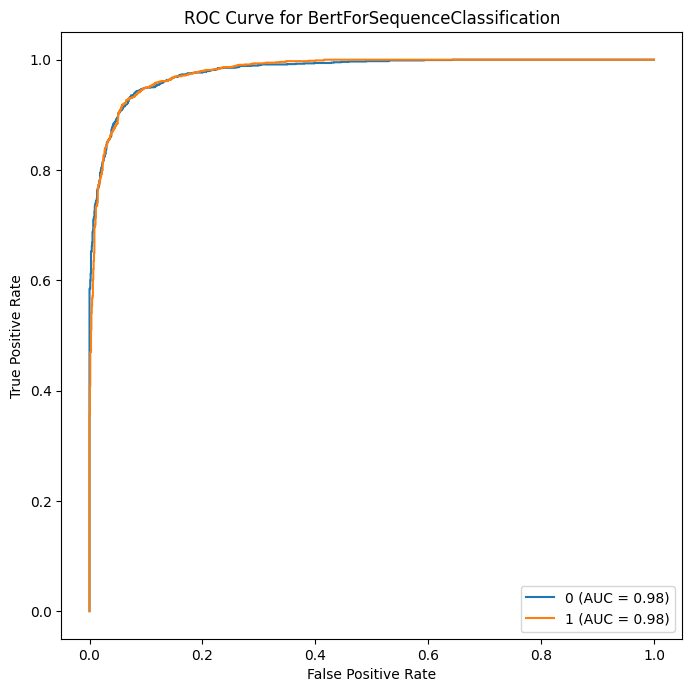

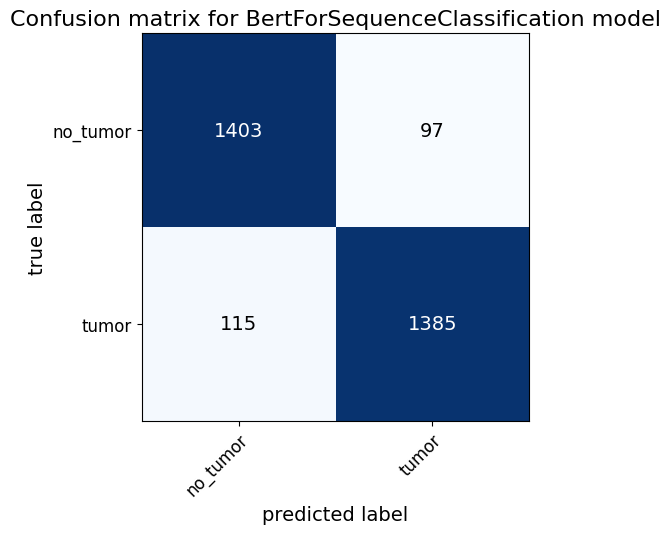

In [ ]:
class_names = {0:'no_tumor', 1:'tumor'}
num_class=len(class_names)

# ROC
plot_roc_curve(model=model,
               y_probs=probs,
               data_set=test_dataset,
               class_names=class_names)

# confusion matrix
CM = confusion_matrix(model=model,
                    y_probs=probs,
                    data_set=test_dataset,
                    class_names=class_names,
                    normalize=False) # True: print the %

### •Analyze confidence scores

In [ ]:
## CONFIDENCE ANALYSIS
confidences = probs.max(dim=1).values  # max probability for each prediction

# Check if prediction is correct
correct_mask = y_pred == y_true
wrong_mask = ~correct_mask

# Split confidences
confidences_correct = confidences[correct_mask]
confidences_wrong = confidences[wrong_mask]

# Print statistics
print(f"\nCorrect predictions: {len(confidences_correct)}")
print(f"Wrong predictions: {len(confidences_wrong)}")

print(f"\nConfidence (correct): mean={confidences_correct.mean():.4f}, std={confidences_correct.std():.4f}, median={confidences_correct.median():.4f}")
print(f"Confidence (wrong):   mean={confidences_wrong.mean():.4f}, std={confidences_wrong.std():.4f}, median={confidences_wrong.median():.4f}")


Correct predictions: 2788
Wrong predictions: 212

Confidence (correct): mean=0.9843, std=0.0588, median=0.9996
Confidence (wrong):   mean=0.8867, std=0.1438, median=0.9557


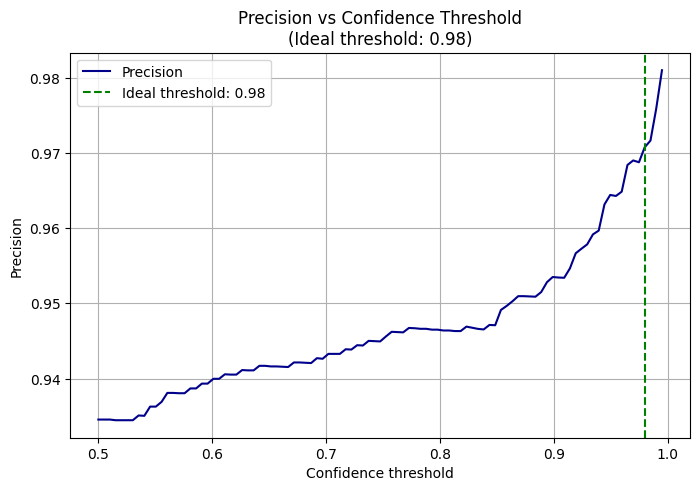

Soglia ideale trovata: 0.980
Numero di predizioni conservate sopra soglia: 2606/3000 (86.87%)


In [ ]:
from sklearn.metrics import precision_score

## find ideal thr for a certain precision
thresholds = np.linspace(0.5, 1.0, 100)
precisions = []
counts = []
desired_precision = 0.97
threshold_ideal = None

probs_np = probs.max(dim=1).values.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()
y_true_np = y_true.cpu().numpy()

for t in thresholds:
    mask = probs_np >= t
    if np.sum(mask) == 0:
        precisions.append(np.nan)
        counts.append(0)
        continue
    y_pred_t = y_pred_np[mask]
    y_true_t = y_true_np[mask]
    precision = precision_score(y_true_t, y_pred_t)
    precisions.append(precision)
    counts.append(np.sum(mask))

for t, p in zip(thresholds, precisions):
    if p is not np.nan and p >= desired_precision:
        threshold_ideal = t
        break

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision", color='darkblue')
if threshold_ideal:
    plt.axvline(x=threshold_ideal, color='green', linestyle='--', label=f"Ideal threshold: {threshold_ideal:.2f}")
    plt.title(f"Precision vs Confidence Threshold\n(Ideal threshold: {threshold_ideal:.2f})")
else:
    plt.title("Precision vs Confidence Threshold\n(No threshold reaches desired precision)")
plt.xlabel("Confidence threshold")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()

if threshold_ideal:
    kept = counts[thresholds.tolist().index(threshold_ideal)]
    print(f"Soglia ideale trovata: {threshold_ideal:.3f}")
    print(f"Numero di predizioni conservate sopra soglia: {kept}/{len(probs_np)} ({kept/len(probs_np)*100:.2f}%)")
else:
    print("⚠️ Nessuna soglia soddisfa la precisione desiderata.")


In [ ]:
threshold = threshold_ideal
high_conf_mask = confidences >= threshold

# correct/wrong
high_conf_correct = correct_mask & high_conf_mask
high_conf_wrong = wrong_mask & high_conf_mask

n_high_conf_total = high_conf_mask.sum().item()
n_high_conf_correct = high_conf_correct.sum().item()
n_high_conf_wrong = high_conf_wrong.sum().item()

high_conf_mask = confidences >= threshold
low_conf_mask = confidences < threshold
false_negatives = correct_mask & low_conf_mask
false_positives = wrong_mask & high_conf_mask
n_false_negatives = false_negatives.sum().item()
n_false_positives = false_positives.sum().item()

# Stampa
print(f"Totale predizioni con confidence ≥ {threshold*100:.0f}%: {n_high_conf_total}")
print(f"✔️  Corrette tra queste: {n_high_conf_correct}")
print(f"❌  Sbagliate tra queste: {n_high_conf_wrong}")
print(f"❗ Predizioni corrette scartate: {n_false_negatives}")
print(f"\nAccuratezza se usassi solo queste: {n_high_conf_correct / n_high_conf_total:.4f}" if n_high_conf_total > 0 else "Nessuna predizione sopra la soglia.")


Totale predizioni con confidence ≥ 98%: 2606
✔️  Corrette tra queste: 2515
❌  Sbagliate tra queste: 91
❗ Predizioni corrette scartate: 273

Accuratezza se usassi solo queste: 0.9651


### •Prediction on PQA-U + filter

In [ ]:
pqa_u = pd.read_parquet('/kaggle/input/pqa-u-original/PQA-U.parquet')

In [ ]:
pqa_u['input_text'] = pqa_u.apply(combine_inputs, axis=1)
pqa_u.head(5)

pubid                                           question  \
0  14499029  Is naturopathy as effective as conventional th...   
1  14499049  Can randomised trials rely on existing electro...   
2  14499672  Is laparoscopic radical prostatectomy better t...   
3  14499773  Does bacterial gastroenteritis predispose peop...   
4  14499777  Is early colonoscopy after admission for acute...   

                                             context  \
0  {'contexts': ['Although the use of alternative...   
1  {'contexts': ['To estimate the feasibility, ut...   
2  {'contexts': ['To compare morbidity in two gro...   
3  {'contexts': ['Irritable bowel syndrome (IBS) ...   
4  {'contexts': ['Urgent colonoscopy has been pro...   

                                         long_answer  \
0  Naturopathy appears to be an effective alterna...   
1  Routine data have the potential to support hea...   
2  The results of our non-randomized study show t...   
3  Symptoms consistent with IBS and functional di...   
4  No significant association is apparent between...   

                                          input_text  
0  question: Is naturopathy as effective as conve...  
1  question: Can randomised trials rely on existi...  
2  question: Is laparoscopic radical prostatectom...  
3  question: Does bacterial gastroenteritis predi...  
4  question: Is early colonoscopy after admission...

In [ ]:
print("Preprocessing...")
pqa_u_test = tokenizer(pqa_u["input_text"].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt") # pt: returns a tensor
print("\nfinished!!")

Preprocessing...

finished!!


In [ ]:
class BioBERT_externaltest_Dataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings  # dict con input_ids e attention_mask

    def __getitem__(self, idx):
        item = {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
        }
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

pqa_u_dataset = BioBERT_externaltest_Dataset(pqa_u_test)
pqa_u_loader = DataLoader(pqa_u_dataset, batch_size=32, shuffle = False)

In [ ]:
## FINE-TUNING
for name, param in model.bert.named_parameters():
    param.requires_grad = False # freeze all the backbone layers


## TRANSFER LEARNING
#for name, param in model.named_parameters():
#    if "classifier" in name or "encoder.layer.11" in name or "encoder.layer.10" in name or "encoder.layer.9" in name:
#        param.requires_grad = True
#    else:
#        param.requires_grad = False

for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n Trainable params: {trainable} / {total} ({100 * trainable / total:.2f}%)")


bert.embeddings.word_embeddings.weight - requires_grad: False
bert.embeddings.position_embeddings.weight - requires_grad: False
bert.embeddings.token_type_embeddings.weight - requires_grad: False
bert.embeddings.LayerNorm.weight - requires_grad: False
bert.embeddings.LayerNorm.bias - requires_grad: False
bert.encoder.layer.0.attention.self.query.weight - requires_grad: False
bert.encoder.layer.0.attention.self.query.bias - requires_grad: False
bert.encoder.layer.0.attention.self.key.weight - requires_grad: False
bert.encoder.layer.0.attention.self.key.bias - requires_grad: False
bert.encoder.layer.0.attention.self.value.weight - requires_grad: False
bert.encoder.layer.0.attention.self.value.bias - requires_grad: False
bert.encoder.layer.0.attention.output.dense.weight - requires_grad: False
bert.encoder.layer.0.attention.output.dense.bias - requires_grad: False
bert.encoder.layer.0.attention.output.LayerNorm.weight - requires_grad: False
bert.encoder.layer.0.attention.output.LayerNorm.

In [ ]:
## make prediction on pqa_u
def predict_unlabeled(model, data_loader, device):
    model.eval()
    y_score = []

    with torch.inference_mode():
        for batch in tqdm(data_loader, desc="Predicting on unlabeled data..."):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            y_score.append(logits.detach().cpu())

    y_score = torch.cat(y_score)
    return y_score

y_unlabeled_scores = predict_unlabeled(model=model, data_loader=pqa_u_loader, device=device)
probs = F.softmax(y_unlabeled_scores, dim=1)
confidences, predictions = probs.max(dim=1)


Predicting on unlabeled data...: 100%|██████████| 1915/1915 [15:39<00:00,  2.04it/s]


In [ ]:
print(probs[0])
print(confidences[0])
print(predictions[0])

tensor([0.0795, 0.9205])
tensor(0.9205)
tensor(1)


In [ ]:
## FILTER
threshold = threshold_ideal
keep_indices = (confidences >= threshold).nonzero(as_tuple=True)[0]
pseudo_X = {
    key: val[keep_indices] for key, val in pqa_u_test.items()
}
pseudo_y = predictions[keep_indices].numpy()
pseudo_conf = confidences[keep_indices].numpy()

print(f"\nCampioni selezionati sopra soglia: {pseudo_X['input_ids'].shape[0]} / {pqa_u_test['input_ids'].shape[0]}")



Campioni selezionati sopra soglia: 41604 / 61249


### •Fine-tuning

In [ ]:
X_train_pseudo = BioBERTDataset(pseudo_X,pseudo_y)
train_pseudo_loader = DataLoader(X_train_pseudo, batch_size=32, shuffle = False)

In [ ]:
# SET TRAINING PARAMETERS
epochs = 50
initial_lr=1e-4
wd=1e-4   # weight_decay

optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=wd) # Adam
criterion = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, min_lr=1e-6, threshold=0.0001, verbose=True)
early_stopping = EarlyStopping(model=model, patience=5)


Epoch 1/50


Training: 100%|██████████| 1301/1301 [11:03<00:00,  1.96it/s]


Train loss: 0.0373 | Train acc: 0.9880


Evaluation...: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]


val loss: 0.3165 | val acc: 0.9232
save: Best results
LR: [0.0001]

Epoch 2/50


Training: 100%|██████████| 1301/1301 [11:03<00:00,  1.96it/s]


Train loss: 0.0378 | Train acc: 0.9883


Evaluation...: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]


val loss: 0.2849 | val acc: 0.9247
save: Best results
LR: [0.0001]

Epoch 3/50


Training: 100%|██████████| 1301/1301 [11:03<00:00,  1.96it/s]


Train loss: 0.0343 | Train acc: 0.9888


Evaluation...: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]


val loss: 0.3026 | val acc: 0.9247
LR: [0.0001]
INFO: Early stopping counter 1 of 4

Epoch 4/50


Training: 100%|██████████| 1301/1301 [11:04<00:00,  1.96it/s]


Train loss: 0.0357 | Train acc: 0.9891


Evaluation...: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]


val loss: 0.3001 | val acc: 0.9247
LR: [0.0001]
INFO: Early stopping counter 2 of 4

Epoch 5/50


Training: 100%|██████████| 1301/1301 [11:04<00:00,  1.96it/s]


Train loss: 0.0360 | Train acc: 0.9880


Evaluation...: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]


val loss: 0.3131 | val acc: 0.9249
LR: [1e-05]
INFO: Early stopping counter 3 of 4

Epoch 6/50


Training: 100%|██████████| 1301/1301 [11:04<00:00,  1.96it/s]


Train loss: 0.0361 | Train acc: 0.9878


Evaluation...: 100%|██████████| 127/127 [01:01<00:00,  2.06it/s]


val loss: 0.3102 | val acc: 0.9249
LR: [1e-05]
INFO: Early stopping counter 4 of 4
INFO: Early stopping
Early stopping
Model saved to LSTM__0.9247.pt.pt


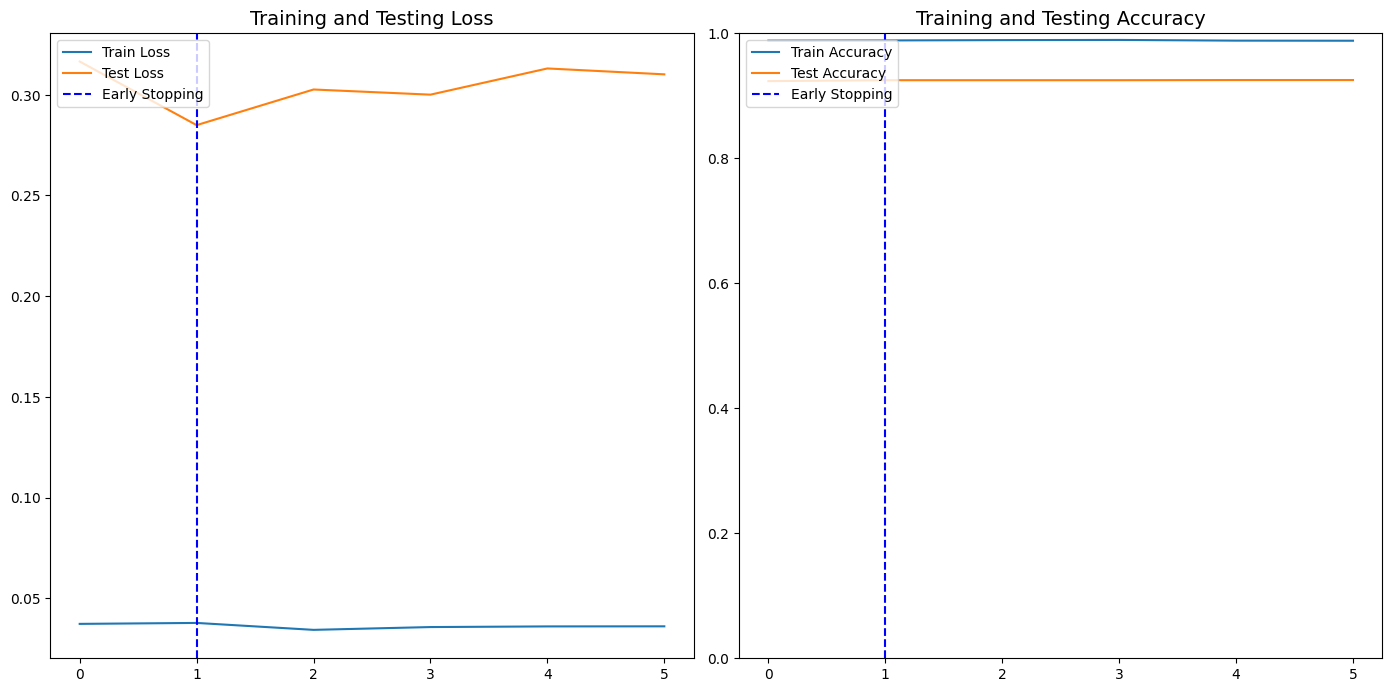

In [ ]:
## TRAIN
model_history, model_filename = fit(NUM_EPOCHS=epochs,
                    model=model,
                    train_data_loader=train_pseudo_loader,
                    val_data_loader=val_loader,
                    scheduler=scheduler,
                    early_stopping=early_stopping,
                    save_dir="",
                    criterion=criterion,
                    optimizer=optimizer,
                    accuracy_fn=accuracy_fn,
                    device=device)
# training curves
plot_training_curves(model=model, history=model_history)

In [ ]:
# Prediction (test set)
y_test_scores, model_test_history = test(model=model,
                                        split='test',
                                        data_loader=test_loader,
                                        criterion=criterion,
                                        accuracy_fn=accuracy_fn,
                                        device=device)

# labels
probs = F.softmax(y_test_scores, dim=1)
y_pred = probs.argmax(dim=1)
y_true = torch.tensor([test_dataset[i]["labels"] for i in range(len(test_dataset))]).long()
print("\npredictions: ", y_pred)
print("real targets: ", y_true)

# metrics
metrics=calculate_metrics(y_pred, y_true, num_classes=2)
for metric, value in metrics.items():
    print(f'{metric}: {value:.4f}')


Evaluation...: 100%|██████████| 94/94 [00:45<00:00,  2.06it/s]

test loss: 0.3201 | test acc: 0.9300

predictions:  tensor([1, 0, 1,  ..., 0, 1, 1])
real targets:  tensor([1, 0, 1,  ..., 0, 1, 1])
accuracy: 0.9300
precision: 0.9301
recall (sensitivity): 0.9300
f1_score: 0.9300
specificity: 0.9300


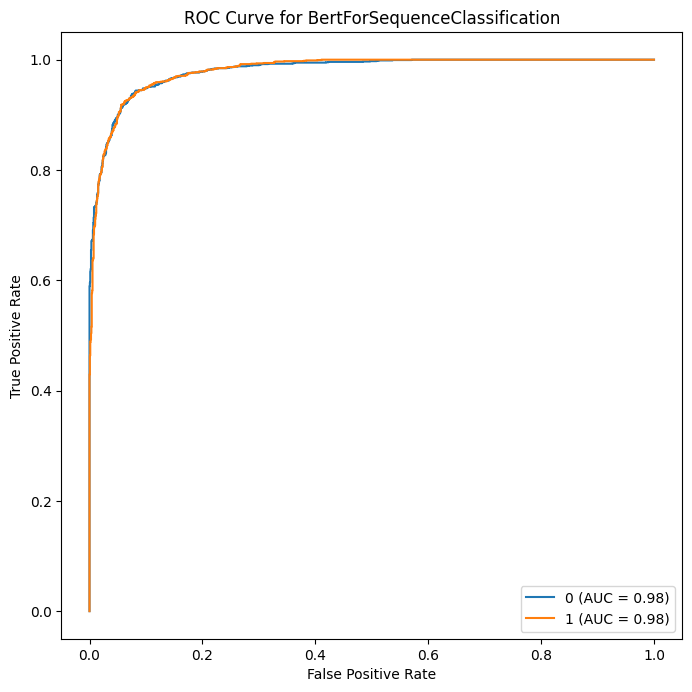

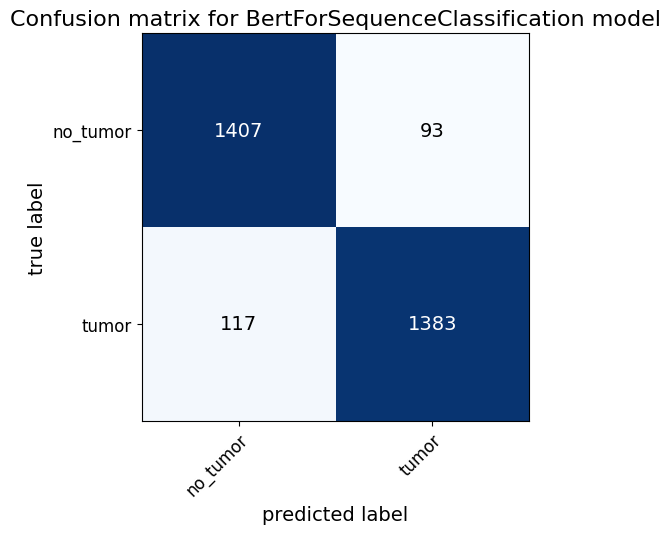

In [ ]:
class_names = {0:'no_tumor', 1:'tumor'}
num_class=len(class_names)

# ROC
plot_roc_curve(model=model,
               y_probs=probs,
               data_set=test_dataset,
               class_names=class_names)

# confusion matrix
CM = confusion_matrix(model=model,
                    y_probs=probs,
                    data_set=test_dataset,
                    class_names=class_names,
                    normalize=False) # True: print the %

### Conclusion

we can see, the performance on the test set slightly increase.

This indicates that the pseudo-labeling strategy is effective in preserving label quality, and that this semi-supervised approach could be a valuable method in scenarios where labeled data is scarce but unlabeled data is available.

## 2.Chatbot Q&A

As a second extension, we developed an interactive chatbot that allows users to input a question (either written or spoken) along with a context (e.g., an abstract from a research paper). The chatbot then automatically generates an appropriate answer.

You can access the chatbot at the following link: https://frammartina.github.io/pubmedqa-chatbot-2/

And the notebook used at the following link: https://colab.research.google.com/drive/1A08CtnARZ8NkYgDqxstVQfVlovMjX7uG?usp=sharing